### 读取数据

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 读取数据
#file_path = "data.csv"
file_path = "E:\数据挖掘\复现论文心脏骤停\mimc+eicu\mimic3.0.+eicu2.0-nosofa.csv"
data = pd.read_csv(file_path)
data.head()

C:\Users\MECHREV\AppData\Local\Temp\ipykernel_31680\2703325790.py:7: DtypeWarning: Columns (13,18,32,34,36,136,140) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,subject_id,hadm_id,stay_id,gender,dod,admittime,dischtime,los_hospital,age,race,...,sbp,sbp_ni,spo2,charttime_weight_durations,weight,oasis,sapsii,sirs,sofa,label
0,10091871.0,26777528,38133597,0.0,94991.0,94741.75000,94752.70833,10.958333,72.388099,WHITE,...,NaN,NaN,NaN,94745.40486,77.0,39,69,3.0,7.0,0
1,11003077.0,28678628,35921053,1.0,NaN,101389.55350,101391.77780,2.224306,38.588841,BLACK/CAPE VERDEAN,...,NaN,NaN,NaN,101389.57640,100.0,25,12,2.0,1.0,0
2,11005929.0,26051211,32548487,1.0,81219.0,81209.79236,81219.04028,9.247917,82.338932,WHITE,...,NaN,NaN,NaN,81209.70903,61.0,39,34,3.0,4.0,0
3,11007136.0,26490512,32778264,0.0,NaN,105501.00000,105505.50140,4.501389,36.846277,WHITE,...,112.0,112.0,NaN,105502.34930,77.1,19,10,1.0,1.0,0
4,11007473.0,29671397,34442228,1.0,83694.0,83686.10278,83694.63194,8.529167,49.120087,HISPANIC/LATINO - PUERTO RICAN,...,NaN,NaN,NaN,83686.50903,89.8,31,56,3.0,11.0,0


### 数据预处理

In [2]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler


# 打印数据预处理前的样本个数
print("数据预处理前的样本个数:", len(data))

# 数据预处理
filtered_data1 = data[data['age'] >= 18]
print("数据预处理后的样本个数 (年龄>=18):", len(filtered_data1))

# filtered_data2 = filtered_data1[filtered_data1['malignant_cancer'] != 1]
# print("数据预处理后的样本个数 (非恶性肿瘤):", len(filtered_data2))

# filtered_data3 = filtered_data2[filtered_data2['metastatic_solid_tumor'] != 1]
# print("数据预处理后的样本个数 (转移性实体肿瘤):", len(filtered_data3)) 

filtered_data4 = filtered_data1[filtered_data1['myocardial_infarct'] != 1]
print("数据预处理后的样本个数 (非心肌梗塞):", len(filtered_data4))

filtered_data5 = filtered_data4[filtered_data4['congestive_heart_failure'] != 1]
print("数据预处理后的样本个数 (非充血性心力衰竭):", len(filtered_data5))

filtered_data6 = filtered_data5[filtered_data5['los_icu_hour'] >= 3]
print("数据预处理后的样本个数 (ICU住院时间>=3小时):", len(filtered_data6))

# 最终处理后的数据
filtered_data = filtered_data6
print("最终数据预处理后的样本个数:", len(filtered_data))

# 打印最终数据集的标签分布情况
label_distribution = filtered_data['label'].value_counts()
print("标签分布情况:")
print(label_distribution)


数据预处理前的样本个数: 191006
数据预处理后的样本个数 (年龄>=18): 190590
数据预处理后的样本个数 (非心肌梗塞): 172136
数据预处理后的样本个数 (非充血性心力衰竭): 152520
数据预处理后的样本个数 (ICU住院时间>=3小时): 150386
最终数据预处理后的样本个数: 150386
标签分布情况:
label
0    146023
1      4363
Name: count, dtype: int64


### 删除缺失值

初始数据: 特征数量=166, 样本数量=150328


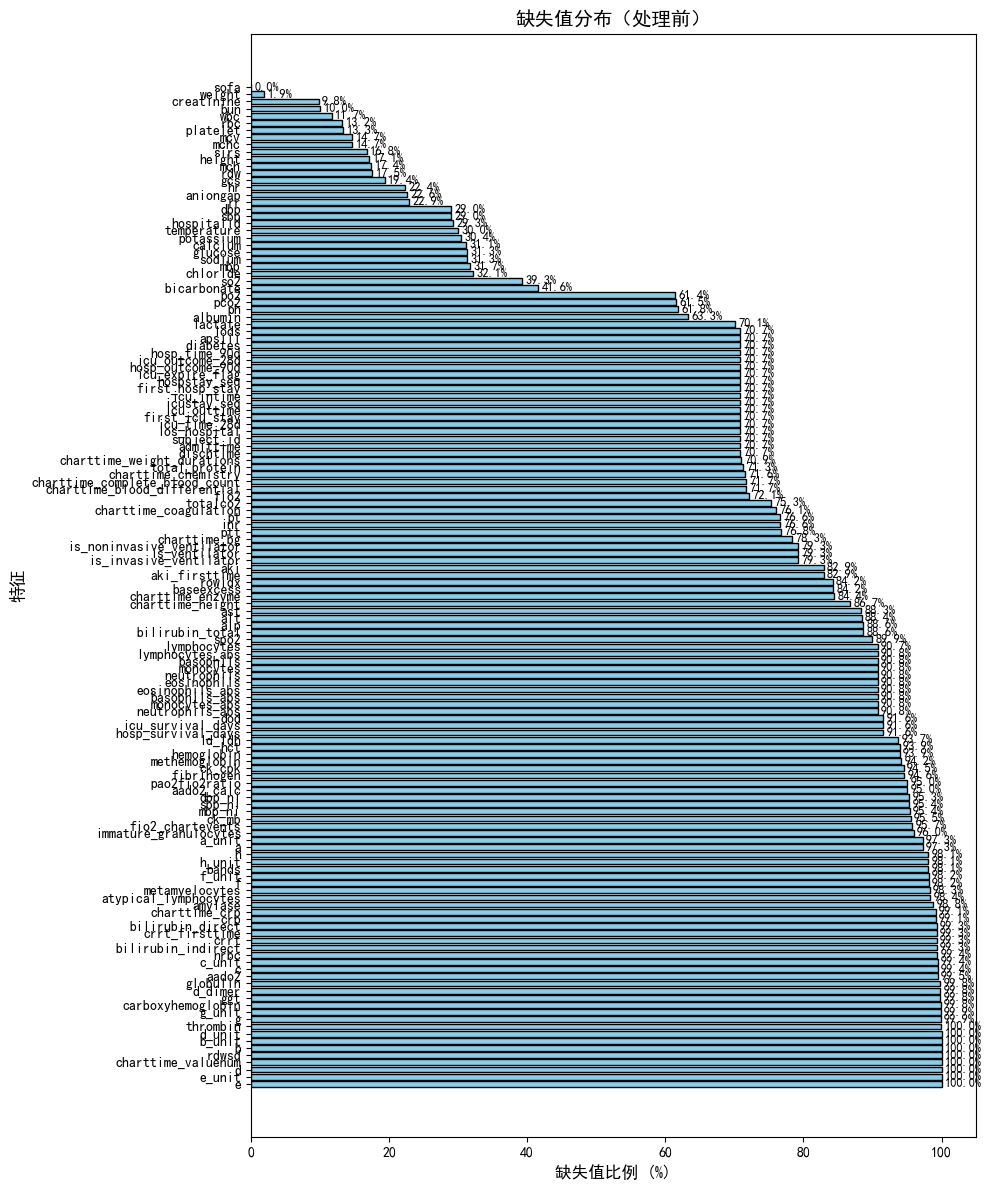

开始分批KNN填充...

最终数据: 特征数量=47, 样本数量=150328

特征统计信息:
          gender        age       race      hadm_id      stay_id  hospitalid  \
count  150328.00  150328.00  150328.00    150328.00    150328.00   150328.00   
mean        0.54      62.15       3.42   8315175.00  11499250.00      195.89   
std         0.00      17.51       1.10  10852504.00  15203705.00      157.93   
min         0.54      18.00       0.00    128948.20    141202.81       -0.00   
25%         0.54      51.38       3.00    896158.06   1198552.62       -0.00   
50%         0.54      64.00       4.00   2146813.75   2677464.75      199.00   
75%         0.54      75.43       4.00  21436789.00  31424170.00      338.00   
max         0.54      99.94       4.00  29999830.00  39999856.00      459.00   

       temperature        wbc  age_score       aids  ...     height  \
count    150328.00  150328.00  150328.00  150328.00  ...  150328.00   
mean         29.60      10.70       2.37       0.00  ...     140.35   
std         359.

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

plt.rcParams.update({'font.sans-serif': ['SimHei'], 'axes.unicode_minus': False})

def process_race(df, race_column='race'):
    keywords = {
        'White': set(['WHITE', 'CAUCASIAN', 'PORTUGUESE', 'EUROPEAN', 'RUSSIAN', 'BRAZILIAN']),
        'Black': set(['BLACK', 'AFRICAN']),
        'Asian': set(['ASIAN', 'CHINESE', 'KOREAN', 'INDIAN']),
        'Hispanic': set(['HISPANIC', 'LATINO', 'SALVADORAN', 'GUATEMALAN', 'HONDURAN', 
                     'MEXICAN', 'DOMINICAN', 'COLUMBIAN', 'CUBAN', 'PUERTO RICAN',
                     'SOUTH AMERICAN', 'CENTRAL AMERICAN'])
    }
    
    def categorize_race(x):
        if pd.isna(x): return 'Other'
        x = str(x).upper()
        for race, kw in keywords.items():
            if any(k in x for k in kw): return race
        return 'Other'
    
    return df[race_column].apply(categorize_race)

def batch_knn_impute(features, batch_size=1000):
    imputer = KNNImputer(n_neighbors=3, weights='distance')
    result_dfs = []
    
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        batch = features.iloc[start:end].astype(np.float32)
        imputed_batch = pd.DataFrame(
            imputer.fit_transform(batch),
            columns=features.columns,
            index=batch.index
        )
        result_dfs.append(imputed_batch)
    
    return pd.concat(result_dfs)

# 分离特征和标签，包含los_icu_hour和hospital_expire_flag
features_analyse = filtered_data[['gender', 'age', 'race', 'los_icu_hour', 'hospital_expire_flag'] + 
    [col for col in filtered_data.columns if col not in 
     ['gender', 'age', 'race', 'label', 'los_icu_hour', 'hospital_expire_flag']]].copy()
labels = filtered_data['label'].copy()

features = filtered_data[['gender', 'age', 'race'] + 
    [col for col in filtered_data.columns if col not in 
     ['gender', 'age', 'race', 'label', 'hospital_expire_flag', 'los_icu_hour']]].copy()
labels = filtered_data['label'].copy()

# 处理种族数据并删除gender为空的样本
features['race'] = process_race(features)
features.dropna(subset=['gender'], inplace=True)
labels = labels[features.index]

# 保存原始索引和打印初始信息
original_index = features.index
print(f"初始数据: 特征数量={features.shape[1]}, 样本数量={features.shape[0]}")

# 处理缺失值和绘图
missing_ratio = (features.isna().sum() / len(features) * 100)
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 12))
bars = plt.barh(missing_ratio.index, missing_ratio, color='skyblue', edgecolor='black')
for bar, ratio in zip(bars, missing_ratio):
    plt.text(ratio + 0.5, bar.get_y() + bar.get_height()/2, f"{ratio:.1f}%", 
             va='center', fontsize=9)
plt.title("缺失值分布（处理前）", fontsize=14)
plt.xlabel("缺失值比例 (%)", fontsize=12)
plt.ylabel("特征", fontsize=12)
plt.tight_layout()
plt.show()

# 删除高缺失率列，但保留los_icu_hour和hospital_expire_flag
high_missing_cols = features.columns[features.isna().sum() > 0.3 * len(features)]
high_missing_cols = [col for col in high_missing_cols 
                    if col not in ['los_icu_hour', 'hospital_expire_flag']]
features.drop(columns=high_missing_cols, inplace=True)

# 标准化数值特征
numeric_features = features.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
features[numeric_features] = scaler.fit_transform(features[numeric_features].fillna(0))

# 编码分类变量
if 'gender' in features.columns:
    features['gender'] = features['gender'].map(lambda x: 1 if str(x).upper().startswith('M') else 0)

if 'race' in features.columns:
    features['race'] = LabelEncoder().fit_transform(features['race'])

# KNN填充
print("开始分批KNN填充...")
features = batch_knn_impute(features)
features[numeric_features] = scaler.inverse_transform(features[numeric_features])

# 数据一致性检查
assert len(features) == len(labels) and (features.index == labels.index).all()

print(f"\n最终数据: 特征数量={features.shape[1]}, 样本数量={features.shape[0]}")
print("\n特征统计信息:")
print(features.describe().round(2))

### 特征的统计学分析

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

# 定义变量列表 - 根据之前处理后的特征调整
continuous_vars = [
'age', 'aniongap','los_icu_hour', 'calcium', 'bun', 'potassium', 'sodium',
'creatinine', 'wbc', 'mchc', 'rdw', 'rbc', 'platelet', 'mcv', 'mch',
'chloride', 'weight', 'height', 'hr', 'sbp', 'dbp', 'mbp',
'rr', 'temperature', 'glucose', 'gcs', 'age_score'
]

categorical_vars = [
    'gender', 'race','peripheral_vascular_disease', 'cerebrovascular_disease',
    'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease',
    'peptic_ulcer_disease', 'mild_liver_disease', 'diabetes', 'paraplegia',
    'renal_disease', 'severe_liver_disease' ,'hospital_expire_flag' # 添加了diabetes
]

def preprocess_data(features, labels):
    """预处理数据"""
    # 合并特征和标签
    data = features_analyse.copy()
    data['label'] = labels
    
    # 将分类变量转回二元类别（除了gender和race）
    for var in categorical_vars:
        if var in data.columns and var not in ['gender', 'race']:
            # 找到最接近0和1的两个值
            unique_vals = sorted(data[var].unique())
            if len(unique_vals) == 2:
                smaller_val = unique_vals[0]
                larger_val = unique_vals[1]
                data[var] = data[var].apply(lambda x: 0 if abs(x - smaller_val) < abs(x - larger_val) else 1)
    
    # 处理分类变量的编码
    for var in categorical_vars:
        if var in data.columns:
            if var == 'gender':
                data[var] = data[var].map({0: 'Female', 1: 'Male'})
            elif var == 'race':
                # race的编码映射关系（根据LabelEncoder的顺序）
                race_mapping = {
                    0: 'White',
                    1: 'Black',
                    2: 'Asian', 
                    3: 'Hispanic',
                    4: 'Other'
                }
                data[var] = data[var].map(race_mapping)
            else:
                data[var] = data[var].map({0: 'No', 1: 'Yes'})
    
    return data

def format_stats(values):
    """格式化统计值（中位数和四分位数范围）"""
    if len(values) == 0:
        return ""
    median = np.median(values)
    q1, q3 = np.percentile(values, [25, 75])
    return f"{median:.2f} ({q1:.2f}, {q3:.2f})"

def analyze_continuous_variable(data, var, group_col='label'):
    """分析连续变量"""
    result = {}
    
    # 移除缺失值
    valid_data = data[[var, group_col]].dropna()
    
    if len(valid_data) == 0:
        return None
    
    # 分组数据
    group0 = valid_data[valid_data[group_col] == 0][var]
    group1 = valid_data[valid_data[group_col] == 1][var]
    
    # 计算统计量
    result['总体'] = format_stats(valid_data[var])
    result['非CA'] = format_stats(group0)
    result['CA'] = format_stats(group1)
    
    # 计算p值
    _, p_value = stats.mannwhitneyu(group0, group1, alternative='two-sided')
    result['P'] = p_value
    
    return result

def analyze_categorical_variable(data, var, group_col='label'):
    """分析分类变量"""
    result = {'categories': {}}
    
    # 移除缺失值
    valid_data = data[[var, group_col]].dropna()
    
    if len(valid_data) == 0:
        return None
    
    # 总样本量
    total = len(valid_data)
    n_group0 = len(valid_data[valid_data[group_col] == 0])
    n_group1 = len(valid_data[valid_data[group_col] == 1])
    
    # 获取所有类别
    categories = sorted(valid_data[var].unique())
    
    # 为每个类别计算统计量
    for category in categories:
        cat_data = valid_data[var] == category
        cat_total = cat_data.sum()
        cat_group0 = ((valid_data[var] == category) & (valid_data[group_col] == 0)).sum()
        cat_group1 = ((valid_data[var] == category) & (valid_data[group_col] == 1)).sum()
        
        result['categories'][category] = {
            '总体': f"{cat_total} ({cat_total/total*100:.2f})",
            '非CA': f"{cat_group0} ({cat_group0/n_group0*100:.2f})",
            'CA': f"{cat_group1} ({cat_group1/n_group1*100:.2f})"
        }
    
    # 计算p值
    contingency = pd.crosstab(valid_data[var], valid_data[group_col])
    if (contingency.values < 5).any():
        _, p_value = stats.fisher_exact(contingency)
    else:
        _, p_value, _, _ = stats.chi2_contingency(contingency)
    
    result['P'] = p_value
    return result

def format_p_value(p):
    """格式化P值"""
    return '<0.001' if p < 0.001 else f'{p:.3f}'

def main_analysis(features, labels):
    """主分析函数"""
    # 预处理数据
    processed_data = preprocess_data(features, labels)
    
    # 存储结果
    results = {}
    
    # 分析连续变量
    for var in continuous_vars:
        if var in processed_data.columns:
            result = analyze_continuous_variable(processed_data, var)
            if result:
                results[f"{var}, M (Q1, Q3)"] = result
    
    # 分析分类变量
    for var in categorical_vars:
        if var in processed_data.columns:
            result = analyze_categorical_variable(processed_data, var)
            if result:
                results[f"{var}, n (%)"] = result
    
    # 转换为DataFrame
    formatted_results = []
    
    for var_name, result in results.items():
        if 'categories' in result:  # 分类变量
            row = pd.Series({'Variable': var_name, 'P': format_p_value(result['P'])})
            formatted_results.append(row)
            
            for category, stats in result['categories'].items():
                cat_row = pd.Series({
                    'Variable': f"    {category}",
                    '总体': stats['总体'],
                    '非CA': stats['非CA'],
                    'CA': stats['CA']
                })
                formatted_results.append(cat_row)
        else:  # 连续变量
            row = pd.Series({
                'Variable': var_name,
                '总体': result['总体'],
                '非CA': result['非CA'],
                'CA': result['CA'],
                'P': format_p_value(result['P'])
            })
            formatted_results.append(row)
    
    df_results = pd.DataFrame(formatted_results)
    
    # 设置列顺序
    cols = ['Variable', '总体', '非CA', 'CA', 'P']
    df_results = df_results[cols]
    
    # 替换NaN为空字符串
    df_results = df_results.replace({np.nan: ''})
    
    return df_results

# 使用预处理后的features和labels进行分析
results_table = main_analysis(features, labels)
print("\n统计分析结果：")
print(results_table.to_string(index=False))


统计分析结果：
                          Variable                      总体                     非CA                      CA      P
                   age, M (Q1, Q3)    64.00 (51.38, 75.43)    64.00 (51.25, 75.39)    65.00 (52.16, 76.00)  0.009
              aniongap, M (Q1, Q3)     12.00 (9.00, 15.00)     12.00 (9.00, 15.00)    14.00 (10.80, 18.00) <0.001
          los_icu_hour, M (Q1, Q3)    41.00 (23.00, 74.00)    41.00 (23.00, 73.00)   63.72 (26.00, 135.72) <0.001
               calcium, M (Q1, Q3)       8.20 (7.50, 8.70)       8.20 (7.50, 8.70)       7.90 (7.10, 8.50) <0.001
                   bun, M (Q1, Q3)    17.00 (12.00, 27.00)    17.00 (12.00, 26.00)    22.00 (15.00, 37.00) <0.001
             potassium, M (Q1, Q3)       4.00 (3.70, 4.40)       4.00 (3.70, 4.40)       4.10 (3.60, 4.70) <0.001
                sodium, M (Q1, Q3) 138.00 (136.00, 141.00) 138.00 (136.00, 141.00) 139.00 (136.00, 142.00) <0.001
            creatinine, M (Q1, Q3)       0.90 (0.70, 1.30)       0.90 (0.70, 1.

### 降采样处理

In [5]:
import numpy as np
# 打印降采样前的标签分布
print("\n降采样前的标签分布：")
print(labels.value_counts())

# 分别获取两个类别的数据
df_0 = features[labels == 0]
df_1 = features[labels == 1]

# 获取少数类的样本数量
num_samples = len(df_1)
print(f"\n少数类样本数: {num_samples}")

# 对多数类进行降采样
df_0_downsampled = df_0.sample(n=num_samples, random_state=42)

# 合并降采样后的数据
features_balanced = pd.concat([df_0_downsampled, df_1])
labels_balanced = pd.concat([pd.Series(0, index=df_0_downsampled.index), 
                           pd.Series(1, index=df_1.index)])

# 打乱数据顺序
idx = np.random.permutation(len(features_balanced))
features = features_balanced.iloc[idx].reset_index(drop=True)
labels = labels_balanced.iloc[idx].reset_index(drop=True)

# 打印降采样后的标签分布
print("\n降采样后的标签分布：")
print(labels.value_counts())


降采样前的标签分布：
label
0    145970
1      4358
Name: count, dtype: int64

少数类样本数: 4358

降采样后的标签分布：
1    4358
0    4358
Name: count, dtype: int64


### 对指定特征进行归一化

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 首先打印当前所有的列名
print("当前所有列名：")
print(features.columns.tolist())

# 定义需要归一化的特征
original_features_to_normalize = ['age', 'aniongap', 'calcium', 'bun', 'potassium', 'sodium',
    'creatinine', 'wbc', 'mchc', 'rdw', 'rbc', 'platelet', 'mcv', 'mch', 'chloride', 'weight',
    'height', 'hr', 'sbp', 'dbp', 'mbp', 'rr', 'temperature', 'glucose']

# 获取实际存在的列和需要归一化的列的交集
available_features = set(features.columns)
normalize_features = set(original_features_to_normalize)
features_to_normalize = list(available_features.intersection(normalize_features))

print("\n缺失的列：")
missing_columns = normalize_features - available_features
print(missing_columns)

print("\n将要归一化的列：")
print(features_to_normalize)

# 提取要归一化的特征
features_to_normalize_data = features[features_to_normalize]

# 保存原始数据的副本
original_features = features.copy()

# 归一化
scaler = StandardScaler()
features_to_normalize_scaled = scaler.fit_transform(features_to_normalize_data)

# 将归一化后的数据转换为 DataFrame
features_to_normalize_scaled_df = pd.DataFrame(
    features_to_normalize_scaled, 
    columns=features_to_normalize, 
    index=features.index
)

# 更新 features DataFrame
features.update(features_to_normalize_scaled_df)

# 检查归一化后的缺失值
missing_values_after_normalization = features.isna().sum()
print("\n归一化后缺失值统计：")
print(missing_values_after_normalization[missing_values_after_normalization > 0])

print("\n归一化后的数据预览：")
print(features.head())

# 保存归一化参数，以便后续使用
scaler_params = {
    'mean_': pd.Series(scaler.mean_, index=features_to_normalize),
    'scale_': pd.Series(scaler.scale_, index=features_to_normalize)
}

print("\n归一化参数：")
print("均值：")
print(scaler_params['mean_'])
print("\n标准差：")
print(scaler_params['scale_'])

# 输出数据的基本统计信息，确认归一化效果
print("\n归一化后的统计信息：")
print(features[features_to_normalize].describe())

当前所有列名：
['gender', 'age', 'race', 'hadm_id', 'stay_id', 'hospitalid', 'temperature', 'wbc', 'age_score', 'aids', 'cerebrovascular_disease', 'charlson_comorbidity_index', 'chronic_pulmonary_disease', 'congestive_heart_failure', 'dementia', 'diabetes_with_cc', 'diabetes_without_cc', 'malignant_cancer', 'metastatic_solid_tumor', 'mild_liver_disease', 'myocardial_infarct', 'paraplegia', 'peptic_ulcer_disease', 'peripheral_vascular_disease', 'renal_disease', 'rheumatic_disease', 'severe_liver_disease', 'aniongap', 'bun', 'creatinine', 'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw', 'gcs', 'height', 'dbp', 'hr', 'rr', 'sbp', 'weight', 'oasis', 'sapsii', 'sirs', 'sofa']

缺失的列：
{'mbp', 'potassium', 'calcium', 'glucose', 'chloride', 'sodium'}

将要归一化的列：
['aniongap', 'mch', 'sbp', 'rbc', 'weight', 'mcv', 'rdw', 'bun', 'age', 'rr', 'wbc', 'hr', 'temperature', 'platelet', 'mchc', 'dbp', 'height', 'creatinine']

归一化后缺失值统计：
Series([], dtype: int64)

归一化后的数据预览：
     gender       age  race       hadm_i

### GFS-RF训练

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from boruta import BorutaPy
import numpy as np
import random

# 设置全局随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


# 定义评估模型的函数
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_sens = recall_score(y_train, y_train_pred)
    test_sens = recall_score(y_test, y_test_pred)
    
    train_spec = recall_score(y_train, y_train_pred, pos_label=0)
    test_spec = recall_score(y_test, y_test_pred, pos_label=0)
    
    train_auroc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auroc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    train_ppv = precision_score(y_train, y_train_pred)
    test_ppv = precision_score(y_test, y_test_pred)
    
    train_npv = precision_score(y_train, y_train_pred, pos_label=0)
    test_npv = precision_score(y_test, y_test_pred, pos_label=0)

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    
    return train_acc, test_acc, train_sens, test_sens, train_spec, test_spec, train_auroc, test_auroc, train_ppv, test_ppv, train_npv, test_npv, train_f1, test_f1, y_test, y_test_pred, model


def pls_feature_selection(X, y, feature_names):
    pls = PLSRegression(n_components=min(X.shape[1], X.shape[0]-1))
    pls.fit(X, y)
    
    # 计算VIP
    t = pls.x_scores_
    q = pls.y_loadings_
    VIP = np.sqrt(np.sum((t ** 2) @ (q.T ** 2), axis=0) / np.sum(t ** 2, axis=0))
    
    # 打印每个特征的VIP值
    print("\nVIP Scores for each feature:")
    print("-" * 40)
    for feature, vip in zip(feature_names, VIP):
        print(f"{feature:<30} {vip:.3f}")
    print("-" * 40)
    
    # 统计信息
    print(f"\nVIP Statistics:")
    print(f"Mean VIP: {np.mean(VIP):.3f}")
    print(f"Max VIP: {np.max(VIP):.3f}")
    print(f"Min VIP: {np.min(VIP):.3f}")
    # 获取最大VIP值对应的特征名称
    max_vip_index = np.argmax(VIP)  # 获取最大VIP值的索引
    max_vip_feature = feature_names[max_vip_index]  # 获取对应的特征名称

    print(f"Max VIP Feature: {max_vip_feature} with VIP: {np.max(VIP):.3f}")
    # 打印特征 'gcs' 的 VIP 值

    print(f"type(VIP): {type(VIP)}")
    print(f"feature_names: {feature_names}")

    if 'gcs' in feature_names:
        gcs_index = feature_names.get_loc('gcs')  # 获取 'gcs' 特征的索引
        gcs_vip = VIP[gcs_index]  # 获取 'gcs' 特征的 VIP 值
        print(f"VIP for 'gcs' feature: {gcs_vip:.3f}")

    else:
        print("'gcs' feature not found in the feature names.")


    # 筛选VIP>1的特征
    selected_features = VIP > 0.5
    if np.sum(selected_features) == 0:
        print("\nWarning: No features with VIP > 1, selecting all features")
        selected_features = np.ones_like(selected_features, dtype=bool)
        
    selected_feature_names = np.array(feature_names)[selected_features]
    print(f"\nSelected {len(selected_feature_names)} features with VIP > 0.5")
    
    return selected_features, selected_feature_names

def boruta_feature_selection(X, y, feature_names):
    # 使用随机森林作为Boruta的基础模型
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)

    # 初始化 Boruta 算法
    boruta = BorutaPy(rf, n_estimators='auto', random_state=42)

    # 训练 Boruta 模型
    boruta.fit(X.values, y)

    # 获取选定的特征
    selected_features = boruta.support_  # 选定特征的布尔值
    rejected_features = boruta.support_weak_  # 被弱拒绝的特征

    # 打印每个特征是否被选中
    print("\nBoruta Feature Selection Results:")
    print("-" * 40)
    for feature, selected in zip(feature_names, selected_features):
        print(f"{feature:<30} {'Selected' if selected else 'Rejected'}")
    print("-" * 40)

    # 获取被选中的特征名称
    selected_feature_names = np.array(feature_names)[selected_features]

    # 获取被拒绝的特征名称
    rejected_feature_names = np.array(feature_names)[rejected_features]
    
    print(f"\nSelected {len(selected_feature_names)} features:")
    print(selected_feature_names)

    print(f"\nRejected {len(rejected_feature_names)} features:")
    print(rejected_feature_names)


# 获取每个特征的重要性排名
    feature_importance = boruta.ranking_  # 每个特征的重要性排名，越小越重要

    # 打印特征的重要性排名
    print("\nFeature Importance Rankings:")
    for feature, importance in zip(feature_names, feature_importance):
        print(f"{feature:<30} Importance Rank: {importance}")

    # 绘制特征重要性排名的条形图
    plt.figure(figsize=(12, 6))
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance Rank': feature_importance
    })
    importance_df = importance_df.sort_values('Importance Rank')
    
    sns.barplot(data=importance_df, x='Importance Rank', y='Feature', palette="Set2")
    plt.title("Feature Importance Rankings", fontsize=16)
    plt.xlabel("Importance Rank (lower is better)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

    return selected_features, selected_feature_names




import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
def gfs_feature_selection(X, y, feature_names, estimator=None, scoring='roc_auc', 
                        max_features=10, min_score_improvement=0.001):
    """贪婪前向搜索特征选择"""
    if estimator is None:
        estimator = DecisionTreeClassifier(
            max_depth=4,
            min_samples_split=20,
            random_state=42
        )

    # 将特征名称转换为列表
    feature_names = list(feature_names)
    selected_features = []
    remaining_features = feature_names.copy()
    best_score = -np.inf
    
    # 设置最大特征数
    max_features = min(max_features, len(feature_names))
    
    # 贪婪前向搜索
    while len(selected_features) < max_features and remaining_features:
        scores = []
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            X_candidate = X[candidate_features]
            
            estimator.fit(X_candidate, y)
            
            if scoring == 'roc_auc':
                probs = estimator.predict_proba(X_candidate)[:, 1]
                score = roc_auc_score(y, probs)
            else:
                score = estimator.score(X_candidate, y)
            
            scores.append((feature, score))
        
        if not scores:
            break
            
        best_feature, best_current_score = max(scores, key=lambda x: x[1])
        
        if (best_current_score - best_score) < min_score_improvement:
            print(f"Stopping: Performance improvement < {min_score_improvement}")
            break
        
        best_score = best_current_score
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        
        print(f"Selected feature: {best_feature} (Score: {best_current_score:.4f})")
    
    if not selected_features:
        print("Warning: No features selected, using first 3 features")
        selected_features = feature_names[:3]
    
    print("\nFinal selected features:")
    for feature in selected_features:
        print(f"- {feature}")
    print(f"Number of selected features: {len(selected_features)}")
    print(f"Best {scoring} score: {best_score:.4f}")
    
    return selected_features, selected_features


def balance_samples(features, labels):
    """
    对数据集进行降采样以平衡正负样本
    
    Parameters:
    -----------
    features : pd.DataFrame
        特征数据
    labels : pd.Series
        标签数据
        
    Returns:
    --------
    features_balanced : pd.DataFrame
        平衡后的特征数据
    labels_balanced : pd.Series
        平衡后的标签数据
    """
    # 获取正负样本的索引
    neg_indices = labels[labels == 0].index
    pos_indices = labels[labels == 1].index
    
    # 打印原始样本分布
    print("\n原始样本分布：")
    print(labels.value_counts())
    
    # 获取少数类的样本数
    min_samples = min(len(neg_indices), len(pos_indices))
    
    # 对多数类进行降采样
    if len(neg_indices) > len(pos_indices):
        neg_indices = np.random.choice(neg_indices, min_samples, replace=False)
    else:
        pos_indices = np.random.choice(pos_indices, min_samples, replace=False)
    
    # 合并采样后的索引
    balanced_indices = np.concatenate([neg_indices, pos_indices])
    np.random.shuffle(balanced_indices)
    
    # 获取平衡后的数据
    features_balanced = features.loc[balanced_indices]
    labels_balanced = labels.loc[balanced_indices]
    
    # 打印平衡后的样本分布
    print("\n平衡后的样本分布：")
    print(labels_balanced.value_counts())
    
    return features_balanced, labels_balanced


from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    # 采样超参数
    n_estimators = trial.suggest_int('n_estimators', 200, 500)
    max_depth = trial.suggest_int('max_depth', 4, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.7, 1.0)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    # 创建模型
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )
    
    
    # Repeated Stratified k-fold cross-validation
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    fold_results = []
    gender_labels = features['gender']
    
    # 首先对整个数据集进行平衡
    features_balanced, labels_balanced = balance_samples(features, labels)
    
    for fold_idx, (train_index, test_index) in enumerate(rskf.split(features_balanced, labels_balanced, gender_labels)):
        X_train, X_test = features_balanced.iloc[train_index], features_balanced.iloc[test_index]
        y_train, y_test = labels_balanced.iloc[train_index], labels_balanced.iloc[test_index]

    # 输出当前折的训练集和测试集正负样本数量
        print(f"\nFold {fold_idx + 1}:")
        print("Training set - Positive samples:", sum(y_train== 1), ", Negative samples:", sum(y_train == 0))
        print("Testing set - Positive samples:", sum(y_test == 1), ", Negative samples:", sum(y_test == 0))

        # PLS特征选择
        selected_features, selected_feature_names = gfs_feature_selection(X_train, y_train, features_balanced.columns)
        X_train_pls = X_train.loc[:, selected_features]
        X_test_pls = X_test.loc[:, selected_features]

        # 评估模型
        results = evaluate_model(model, X_train_pls, y_train, X_test_pls, y_test)
        train_acc, test_acc, train_sens, test_sens, train_spec, test_spec, train_auroc, test_auroc, train_ppv, test_ppv, train_npv, test_npv, train_f1, test_f1, y_test, y_test_pred, model = results
        
        fold_results.append({
            'fold_idx': fold_idx + 1,
            'train_index': train_index,
            'test_index': test_index,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'train_sens': train_sens,
            'test_sens': test_sens,
            'train_spec': train_spec,
            'test_spec': test_spec,
            'train_auroc': train_auroc,
            'test_auroc': test_auroc,
            'train_ppv': train_ppv,
            'test_ppv': test_ppv,
            'train_npv': train_npv,
            'test_npv': test_npv,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'selected_feature_names': selected_feature_names,
            'y_test': y_test,
            'y_test_pred': y_test_pred,
            'model': model
        })
    
    # 返回平均测试准确率作为Optuna优化的目标
    trial.set_user_attr("fold_results", fold_results)
    return np.mean([result['test_acc'] for result in fold_results])


d:\Anaconda3\envs\zss\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 找到最佳折对应的特征和超参数-RF训练

In [8]:
# 创建Optuna的study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

# 获取最佳试验和相应的结果
best_trial = study.best_trial
best_fold_results = best_trial.user_attrs["fold_results"]

# 找到最佳折
best_fold_idx = np.argmax([result['test_auroc'] for result in best_fold_results])
best_fold_result = best_fold_results[best_fold_idx]

# 打印最佳折的评估指标
print("\nBest fold evaluation metrics:")
print(f"  Fold {best_fold_result['fold_idx']}")
print(f"  Train Accuracy: {best_fold_result['train_acc']:.4f}")
print(f"  Test Accuracy: {best_fold_result['test_acc']:.4f}")
print(f"  Train Sensitivity: {best_fold_result['train_sens']:.4f}")
print(f"  Test Sensitivity: {best_fold_result['test_sens']:.4f}")
print(f"  Train Specificity: {best_fold_result['train_spec']:.4f}")
print(f"  Test Specificity: {best_fold_result['test_spec']:.4f}")
print(f"  Train AUROC: {best_fold_result['train_auroc']:.4f}")
print(f"  Test AUROC: {best_fold_result['test_auroc']:.4f}")
print(f"  Train PPV: {best_fold_result['train_ppv']:.4f}")
print(f"  Test PPV: {best_fold_result['test_ppv']:.4f}")
print(f"  Train NPV: {best_fold_result['train_npv']:.4f}")
print(f"  Test NPV: {best_fold_result['test_npv']:.4f}")
print(f"  Train F1 Score: {best_fold_result['train_f1']:.4f}")
print(f"  Test F1 Score: {best_fold_result['test_f1']:.4f}")

# 获取最佳折中选择的特征
selected_features_final = best_fold_result['selected_feature_names']
print("Selected features for best fold:", selected_features_final)
print(f"Number of selected features: {len(selected_features_final)}")

[I 2025-02-24 10:10:53,838] A new study created in memory with name: no-name-11529785-846e-4d8a-88c0-2d3f1da05980
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(



原始样本分布：
1    4358
0    4358
Name: count, dtype: int64

平衡后的样本分布：
1    4358
0    4358
Name: count, dtype: int64

Fold 1:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 872 , Negative samples: 872
Selected feature: sofa (Score: 0.7608)
Selected feature: gcs (Score: 0.7984)
Selected feature: sapsii (Score: 0.8076)
Selected feature: rr (Score: 0.8109)
Stopping: Performance improvement < 0.001

Final selected features:
- sofa
- gcs
- sapsii
- rr
Number of selected features: 4
Best roc_auc score: 0.8109

Fold 2:
Training set - Positive samples: 3486 , Negative samples: 3487
Testing set - Positive samples: 872 , Negative samples: 871
Selected feature: sofa (Score: 0.7651)
Selected feature: gcs (Score: 0.8034)
Selected feature: sapsii (Score: 0.8130)
Selected feature: oasis (Score: 0.8162)
Stopping: Performance improvement < 0.001

Final selected features:
- sofa
- gcs
- sapsii
- oasis
Number of selected features: 4
Best roc_auc score: 0.8162

F

[I 2025-02-24 10:11:04,528] Trial 0 finished with value: 0.751605701969082 and parameters: {'n_estimators': 244, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 0.9797018344855175, 'bootstrap': True}. Best is trial 0 with value: 0.751605701969082.



Best fold evaluation metrics:
  Fold 3
  Train Accuracy: 0.7615
  Test Accuracy: 0.7613
  Train Sensitivity: 0.7507
  Test Sensitivity: 0.7580
  Train Specificity: 0.7723
  Test Specificity: 0.7646
  Train AUROC: 0.8362
  Test AUROC: 0.8296
  Train PPV: 0.7672
  Test PPV: 0.7633
  Train NPV: 0.7560
  Test NPV: 0.7594
  Train F1 Score: 0.7589
  Test F1 Score: 0.7606
Selected features for best fold: ['sofa', 'gcs', 'sapsii', 'oasis']
Number of selected features: 4


### 上述找到的最佳6个特征

In [9]:
selected_features_final =['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']

### RF重新训练-五折平均结果

In [10]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBClassifier
import numpy as np
from sklearn.utils import resample

# 定义计算均值和置信区间的函数
def compute_mean_and_ci(results, metric_idx):
    metrics = np.array([result[metric_idx] for result in results])
    mean = np.mean(metrics)
    ci = 1.96 * np.std(metrics) / np.sqrt(len(metrics))  # 95% 置信区间
    return mean, ci

# 定义评估指标列表
metrics = ['Train Accuracy', 'Test Accuracy', 'Train Sensitivity', 'Test Sensitivity', 
          'Train Specificity', 'Test Specificity', 'Train AUROC', 'Test AUROC', 
          'Train PPV', 'Test PPV', 'Train NPV', 'Test NPV', 'Train F1 Score', 'Test F1 Score']

# 使用最佳超参数和最佳特征重新在整个数据集上进行5折交叉验证
best_params = best_trial.params
model = RandomForestClassifier(**best_params)
print("best_params:", best_params)
# 获取最佳特征
#selected_features_final = best_fold_result['selected_feature_names']
print("Selected features:", selected_features_final)
print(f"Number of selected features: {len(selected_features_final)}")
# 使用pandas的列名选择而不是位置索引
X_final = features[selected_features_final]  
gender_labels = features['gender']

# Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
final_fold_results = []
y_test_all = []
y_test_pred_all = []
final_y_pred_prob = []

def balance_samples(X, y, random_state=42):
    """平衡正负样本"""
    # 将y转换为DataFrame并赋予列名
    if isinstance(y, pd.Series):
        y = pd.DataFrame(y)
    else:
        y = pd.DataFrame(y, columns=['target'])
    
    # 合并X和y
    X_y = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    
    # 获取标签列名
    y_col = y.columns[0]
    
    # 分离正负样本
    negative_samples = X_y[X_y[y_col] == 0]
    positive_samples = X_y[X_y[y_col] == 1]
    
    # 获取较少类别的样本数
    min_samples = min(len(negative_samples), len(positive_samples))
    
    # 对较多的类别进行降采样
    if len(negative_samples) > min_samples:
        negative_samples = resample(negative_samples, 
                                  n_samples=min_samples,
                                  random_state=random_state)
    if len(positive_samples) > min_samples:
        positive_samples = resample(positive_samples,
                                  n_samples=min_samples,
                                  random_state=random_state)
    
    # 合并样本
    balanced_samples = pd.concat([negative_samples, positive_samples])
    
    # 打乱顺序
    balanced_samples = balanced_samples.sample(frac=1, random_state=random_state)
    
    # 分离特征和标签
    X_balanced = balanced_samples[X.columns]
    y_balanced = balanced_samples[y_col]
    
    return X_balanced, y_balanced

# 重复 5 折交叉验证，并确保性别和标签的分层抽样
for fold_idx, (train_index, test_index) in enumerate(rskf.split(X_final, labels,gender_labels)):
    X_train_fold_orig, X_test_fold = X_final.iloc[train_index], X_final.iloc[test_index]
    y_train_fold_orig, y_test_fold = labels.iloc[train_index], labels.iloc[test_index]
    
    # 平衡训练集
    X_train_fold, y_train_fold = balance_samples(X_train_fold_orig, y_train_fold_orig)
    # 平衡测试集
    X_test_fold, y_test_fold = balance_samples(X_test_fold, y_test_fold)
    
    # 输出当前折的训练集和测试集正负样本数量
    print(f"\nFold {fold_idx + 1}:")
    print("Training set - Positive samples:", sum(y_train_fold == 1), ", Negative samples:", sum(y_train_fold == 0))
    print("Testing set - Positive samples:", sum(y_test_fold == 1), ", Negative samples:", sum(y_test_fold == 0))
    
    # # 使用定义好的 PLS 特征选择函数
    # selected_features, selected_feature_names = pls_feature_selection(X_train_fold, y_train_fold, X_train_fold.columns)
    # X_train_pls = X_train_fold.loc[:, selected_features]
    # X_test_pls = X_test_fold.loc[:, selected_features]
    
    # # 输出选择的特征
    # print(f"Selected features for fold {fold_idx + 1}:", selected_feature_names)
    # print(f"Number of selected features: {len(selected_feature_names)}")

    ### 疑问可以打印一下每折的特征确定是不是上面选的12个么？

    # 打印当前折使用的特征
    print("\nFeatures used in this fold:")
    for i, feature in enumerate(X_train_fold.columns, 1):
        print(f"{i}. {feature}")
    print("-" * 50)  # 添加分隔线使输出更清晰


    # 训练XGBoost模型并获取预测概率
    model.fit(X_train_fold, y_train_fold)
    y_test_prob = model.predict_proba(X_test_fold)[:, 1]
    
    # 收集真实标签和预测概率
    y_test_all.extend(y_test_fold)
    final_y_pred_prob.extend(y_test_prob)
    
    # 评估模型
    final_results = evaluate_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    final_fold_results.append(final_results)

# 计算最终的混淆矩阵预测
final_y_pred = np.array([1 if prob >= 0.5 else 0 for prob in final_y_pred_prob])

# 输出最终的长度检查
print(f"\nTotal true labels: {len(y_test_all)}")
print(f"Total predicted probabilities: {len(final_y_pred_prob)}")

# 打印每一折的评估结果
for idx, result in enumerate(final_fold_results, 1):
    train_acc, test_acc, train_sens, test_sens, train_spec, test_spec, train_auroc, test_auroc, train_ppv, test_ppv, train_npv, test_npv, train_f1, test_f1, y_test, y_test_pred, model = result
    print(f"\nFold {idx} evaluation metrics after refitting:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Train Sensitivity: {train_sens:.4f}")
    print(f"  Test Sensitivity: {test_sens:.4f}")
    print(f"  Train Specificity: {train_spec:.4f}")
    print(f"  Test Specificity: {test_spec:.4f}")
    print(f"  Train AUROC: {train_auroc:.4f}")
    print(f"  Test AUROC: {test_auroc:.4f}")
    print(f"  Train PPV: {train_ppv:.4f}")
    print(f"  Test PPV: {test_ppv:.4f}")
    print(f"  Train NPV: {train_npv:.4f}")
    print(f"  Test NPV: {test_npv:.4f}")
    print(f"  Train F1: {train_f1:.4f}")
    print(f"  Test F1: {test_f1:.4f}")

# 计算并打印平均指标
print("\nOverall Performance:")
for idx, metric in enumerate(metrics):
    mean, ci = compute_mean_and_ci(final_fold_results, idx)
    print(f'{metric}: Mean = {mean:.3f}, 95% CI = [{mean-ci:.3f}, {mean+ci:.3f}]')

d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


best_params: {'n_estimators': 244, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 0.9797018344855175, 'bootstrap': True}
Selected features: ['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']
Number of selected features: 6

Fold 1:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 872 , Negative samples: 872

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 2:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 3:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
---

### RF-SHAP图

Fold 1: SHAP values
Number of features: 6
SHAP values type: <class 'list'>
SHAP values shapes: [(1744, 6), (1744, 6)]
SHAP_value shape: (2, 1744, 6)
X_test shape: (1744, 6)
Features: ['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']


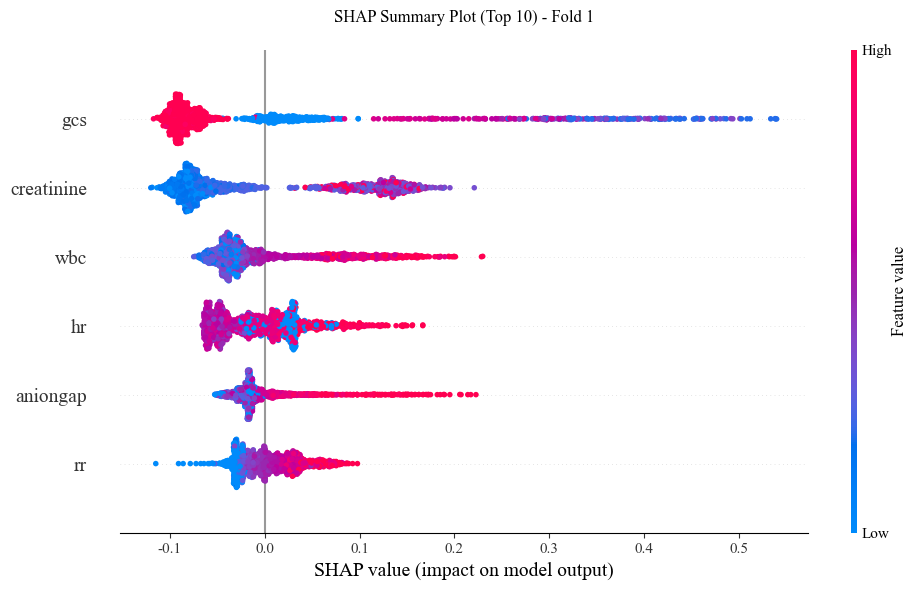

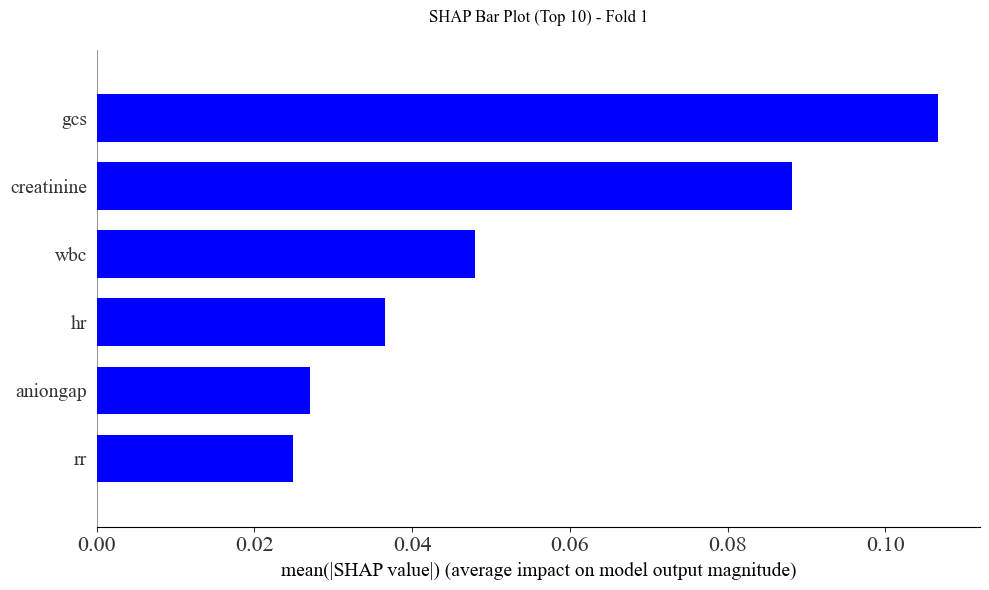

Error in fold 1: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).
Shapes: (6972, 6) (6972,) (1744, 6) (1744,)


<Figure size 1200x400 with 0 Axes>

In [11]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Global plot settings
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 26
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 26
FEATURE_FONT_SIZE = 14

def create_shap_plots(X_resampled, y_resampled, selected_features_final, best_params, rskf):
    """Generate SHAP plots for each fold"""
    
    for fold_idx, (train_index, test_index) in enumerate(rskf.split(X_resampled, y_resampled)):
        print(f'Fold {fold_idx+1}: SHAP values')
        
        # Get fold data
        X_train_fold_orig = X_resampled.iloc[train_index]
        y_train_fold_orig = y_resampled[train_index]
        X_test_fold_orig = X_resampled.iloc[test_index]
        y_test_fold_orig = y_resampled[test_index]
        
        # Balance datasets
        X_train_fold, y_train_fold = balance_samples(X_train_fold_orig, y_train_fold_orig)
        X_test_fold, y_test_fold = balance_samples(X_test_fold_orig, y_test_fold_orig)
        
        try:
            # Train model with best parameters
            model = RandomForestClassifier(**best_params)
            model.fit(X_train_fold, y_train_fold)
            
            # Calculate SHAP values
            explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
            shap_values = explainer.shap_values(X_test_fold)
            
            # Ensure correct shape for plotting
            if isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
                shap_values = [shap_values[:,:,0], shap_values[:,:,1]]
            
            # Debug SHAP values
            print("Number of features:", len(X_test_fold.columns))
            print("SHAP values type:", type(shap_values))
            if isinstance(shap_values, list):
                print("SHAP values shapes:", [sv.shape for sv in shap_values])
            else:
                print("SHAP values shape:", shap_values.shape)

            # Print shapes for debugging
            print("SHAP_value shape:", np.array(shap_values).shape if isinstance(shap_values, list) else shap_values.shape)
            print("X_test shape:", X_test_fold.shape)
            print("Features:", list(X_test_fold.columns))
            
            # Summary plot
            plt.figure(figsize=(12, 8))
            with plt.style.context({'font.family': 'Times New Roman'}):
                shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values
                shap.summary_plot(
                    shap_values_plot,
                    X_test_fold,
                    show=False,
                    plot_size=(10, 6),
                    max_display=len(X_test_fold.columns)  # 显示所有特征
                )
                
                ax = plt.gca()
                ax.set_title(f'SHAP Summary Plot (Top 10) - Fold {fold_idx+1}', 
                           fontfamily='Times New Roman', 
                           fontsize=12, 
                           pad=20)
                ax.set_xlabel(ax.get_xlabel(), fontfamily='Times New Roman', fontsize=14)
                ax.set_ylabel(ax.get_ylabel(), fontfamily='Times New Roman', fontsize=12)
                ax.tick_params(axis='y', labelsize=FEATURE_FONT_SIZE)
                
                plt.tight_layout()
                plt.show()
            
            # Bar plot
            plt.figure(figsize=(10, 6))
            with plt.style.context({'font.family': 'Times New Roman'}):
                shap.summary_plot(
                    shap_values_plot,
                    X_test_fold,
                    plot_type="bar",
                    show=False,
                    plot_size=(10, 6),
                    max_display=len(X_test_fold.columns)  # 显示所有特征
                )
                    # 修改颜色
                ax = plt.gca()
                bars = ax.patches  # 获取所有条形图的对
                for bar in bars:
                    bar.set_facecolor('blue')  # 设置条形图的颜色为蓝色
                ax.set_title(f'SHAP Bar Plot (Top 10) - Fold {fold_idx+1}', 
                fontfamily='Times New Roman', fontsize=12, pad=20)
                ax.set_xlabel(ax.get_xlabel(), fontfamily='Times New Roman', fontsize=14)
                ax.set_ylabel(ax.get_ylabel(), fontfamily='Times New Roman', fontsize=12)
                ax.tick_params(axis='both', which='major', labelsize=16, labelrotation=0)
                ax.tick_params(axis='y', labelsize=FEATURE_FONT_SIZE)
                
                plt.tight_layout()
                plt.show()
            
            # Force plot for example instances
            positive_indices = np.where(y_resampled == 1)[0]
            negative_indices = np.where(y_resampled == 0)[0]
            
            if len(positive_indices) > 0 and len(negative_indices) > 0:
                first_positive = X_test_fold.iloc[0]
                first_negative = X_test_fold.iloc[-1]
                
                shap_values_pos = explainer.shap_values(first_positive)
                shap_values_neg = explainer.shap_values(first_negative)
                
                plt.figure(figsize=(12, 4))
                shap.force_plot(
                    explainer.expected_value,
                    shap_values_pos[1] if isinstance(shap_values_pos, list) else shap_values_pos,
                    first_positive,
                    show=False,
                    matplotlib=True
                )
                plt.title("Force Plot - Positive Example", fontfamily='Times New Roman', fontsize=12)
                plt.tight_layout()
                plt.show()
            
        except Exception as e:
            print(f"Error in fold {fold_idx+1}:", str(e))
            print("Shapes:", X_train_fold.shape, y_train_fold.shape, X_test_fold.shape, y_test_fold.shape)
            break

# Usage
X_resampled = X_final[selected_features_final]
create_shap_plots(X_resampled, labels, selected_features_final, best_params, rskf)

### RF-SHAP图正样本

In [12]:
# first_positive_index=150
# # 打印标签
# print("Index", first_positive_index, "的标签是:", y_resampled.iloc[first_positive_index])
# import shap
# shap.initjs()

# # 获取正样本的特征值和 SHAP 值
# selected_features = [
#     'age', 'aniongap', 'bun', 'creatinine', 
#     'wbc', 'rbc', 'weight', 'hr', 'rr', 
#     'temperature', 'glucose', 'gcs'
# ]

# # 从original_features中提取这些特征
# sample_features = original_features[selected_features].iloc[first_positive_index]
# sample_shap_values = shap_values[first_positive_index]

# # 打印维度信息进行调试
# print("Debug information:")
# print(f"sample_features length: {len(sample_features)}")
# print(f"sample_shap_values length: {len(sample_shap_values)}")

# # 使用较小的长度来确保不会越界
# min_length = min(len(sample_features), len(sample_shap_values))
# from itertools import zip_longest

# # 使用fillvalue参数指定当一个列表耗尽时使用的填充值
# for feature, shap_value in zip_longest(sample_features, sample_shap_values, fillvalue=None):
#     print(f"Feature: {feature}, SHAP Value: {shap_value}")
    
# print("\nFeature values and corresponding SHAP values for the positive sample:")
# print(f"{'Feature':<25} {'Value':<15} {'SHAP Value':<15}")
# print("-" * 55)
# for i in range(min_length):
#     feature_name = selected_features[i]
#     feature_value = sample_features[feature_name]  # 使用特征名而不是索引
#     shap_value = sample_shap_values[i]
#     print(f"{feature_name:<25} {feature_value:>15.4f} {shap_value:>15.4f}")

# # 绘制force plot
# shap.plots.force(
#     explainer.expected_value,
#     sample_shap_values[:min_length],
#     sample_features.values[:min_length],
#     feature_names=selected_features[:min_length]
# )

### RF-SHAP图负样本

In [13]:
# first_negative_index=35
# # 打印标签
# print("Index", first_negative_index, "的标签是:", y_resampled.iloc[first_negative_index])

# # import shap
# # shap.initjs()

# # shap.plots.force(
# #     explainer.expected_value,
# #     shap_values[first_negative_index],
# #     X_test_fold.iloc[first_negative_index])  # 传递特征数据

# import shap
# shap.initjs()

# # 获取正样本的特征值和 SHAP 值
# selected_features = [
#     'age', 'aniongap', 'bun', 'creatinine', 
#     'wbc', 'rbc', 'weight', 'hr', 'rr', 
#     'temperature', 'glucose', 'gcs'
# ]

# # 从original_features中提取这些特征
# sample_features = original_features[selected_features].iloc[first_negative_index]
# sample_shap_values = shap_values[first_negative_index]

# # 打印维度信息进行调试
# print("Debug information:")
# print(f"sample_features length: {len(sample_features)}")
# print(f"sample_shap_values length: {len(sample_shap_values)}")

# # 使用较小的长度来确保不会越界
# min_length = min(len(sample_features), len(sample_shap_values))

# print("\nFeature values and corresponding SHAP values for the positive sample:")
# print(f"{'Feature':<25} {'Value':<15} {'SHAP Value':<15}")
# print("-" * 55)
# for i in range(min_length):
#     feature_name = selected_features[i]
#     feature_value = sample_features[feature_name]  # 使用特征名而不是索引
#     shap_value = sample_shap_values[i]
#     print(f"{feature_name:<25} {feature_value:>15.4f} {shap_value:>15.4f}")

# # 绘制force plot
# shap.plots.force(
#     explainer.expected_value,
#     sample_shap_values[:min_length],
#     sample_features.values[:min_length],
#     feature_names=selected_features[:min_length]
# )


### RF-ROC曲线和混淆矩阵图

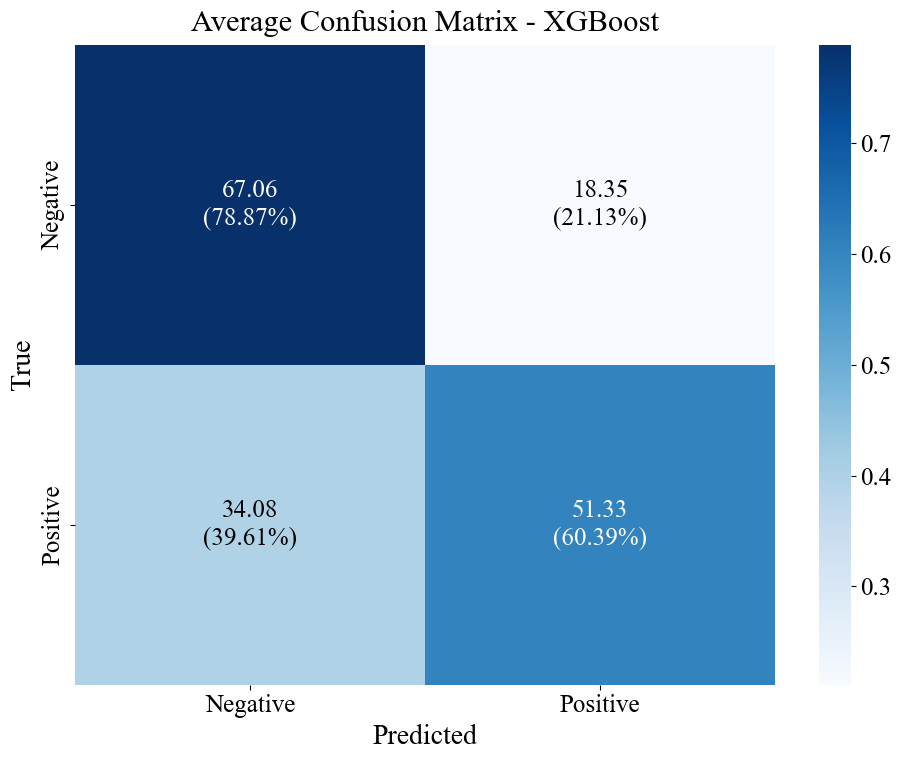

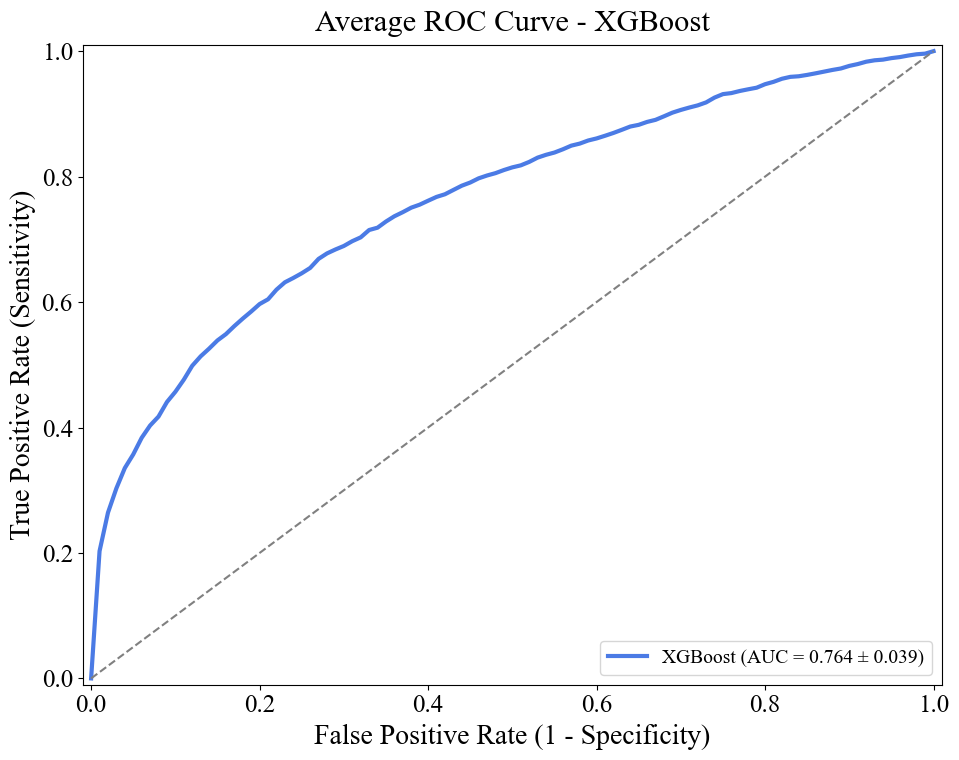

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 设置全局参数
plt.rcParams.update({
   'font.family': 'Times New Roman',
   'font.size': 20,
   'axes.labelsize': 20, 
   'axes.titlesize': 22,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18
})

def plot_average_confusion_matrix(y_true_list, y_pred_list, title):
    plt.figure(figsize=(10, 8), dpi=100)
    
    # 重塑数据为50个折叠
    n_samples_per_fold = len(y_true_list) // 50
    y_true_folds = [y_true_list[i:i + n_samples_per_fold] 
                    for i in range(0, len(y_true_list), n_samples_per_fold)]
    y_pred_folds = [y_pred_list[i:i + n_samples_per_fold] 
                    for i in range(0, len(y_pred_list), n_samples_per_fold)]
    
    # 计算每个折叠的混淆矩阵
    cms = [confusion_matrix(y_true, y_pred)
           for y_true, y_pred in zip(y_true_folds, y_pred_folds)]
    
    # 计算每个折叠的归一化混淆矩阵
    cms_normalized = [cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] for cm in cms]
    
    # 计算平均混淆矩阵
    avg_cm = np.mean(cms, axis=0)
    avg_cm_normalized = np.mean(cms_normalized, axis=0)
    
    # 绘制热力图
    ax = sns.heatmap(avg_cm_normalized, annot=False, fmt='.2%', cmap='Blues',
                     xticklabels=['Negative', 'Positive'], 
                     yticklabels=['Negative', 'Positive'], cbar=True)
    
    # 在每个格子中显示文本标注
    for i in range(2):
        for j in range(2):
            plt.text(j + 0.5, i + 0.5,
                    f'{avg_cm[i, j]:.2f}\n({avg_cm_normalized[i, j]:.2%})',
                    ha='center', va='center',
                    family='Times New Roman',
                    fontsize=18,
                    color='white' if avg_cm_normalized[i, j] > 0.5 else 'black')
    
    plt.title(f'Average Confusion Matrix - {title}', pad=10)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

def plot_average_roc_curve(y_true_list, y_prob_list, title):
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    
    plt.figure(figsize=(10, 8), dpi=100)
    
    # 重塑数据为50个折叠
    n_samples_per_fold = len(y_true_list) // 50
    y_true_folds = [y_true_list[i:i + n_samples_per_fold] 
                    for i in range(0, len(y_true_list), n_samples_per_fold)]
    y_prob_folds = [y_prob_list[i:i + n_samples_per_fold] 
                    for i in range(0, len(y_prob_list), n_samples_per_fold)]
    
    # 计算每个折叠的ROC曲线
    for y_true, y_prob in zip(y_true_folds, y_prob_folds):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    
    # 计算AUC的平均值和95%置信区间
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    ci_auc = 1.96 * std_auc / np.sqrt(len(aucs))
    
    # 计算TPR的95%置信区间
    tpr_upper = np.minimum(mean_tprs + 1.96 * std_tprs / np.sqrt(len(tprs)), 1)
    tpr_lower = np.maximum(mean_tprs - 1.96 * std_tprs / np.sqrt(len(tprs)), 0)
    
    # 绘制ROC曲线，使用XGBoost的标准蓝色
    plt.plot(base_fpr, mean_tprs, '-', 
            color='#4B7BE5',
            label=f'XGBoost (AUC = {mean_auc:.3f} ± {std_auc:.3f})',
            linewidth=3)

    # 绘制对角线
    plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=1.5)
    
    # 设置坐标轴范围
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'Average ROC Curve - {title}', pad=10)
    
    # 调整图例
    plt.legend(loc='lower right', fontsize=14, frameon=True)
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()

# 调用函数
plot_average_confusion_matrix(y_test_all, final_y_pred, "XGBoost")
plot_average_roc_curve(y_test_all, final_y_pred_prob, "XGBoost")

### RF-DCA决策曲线图

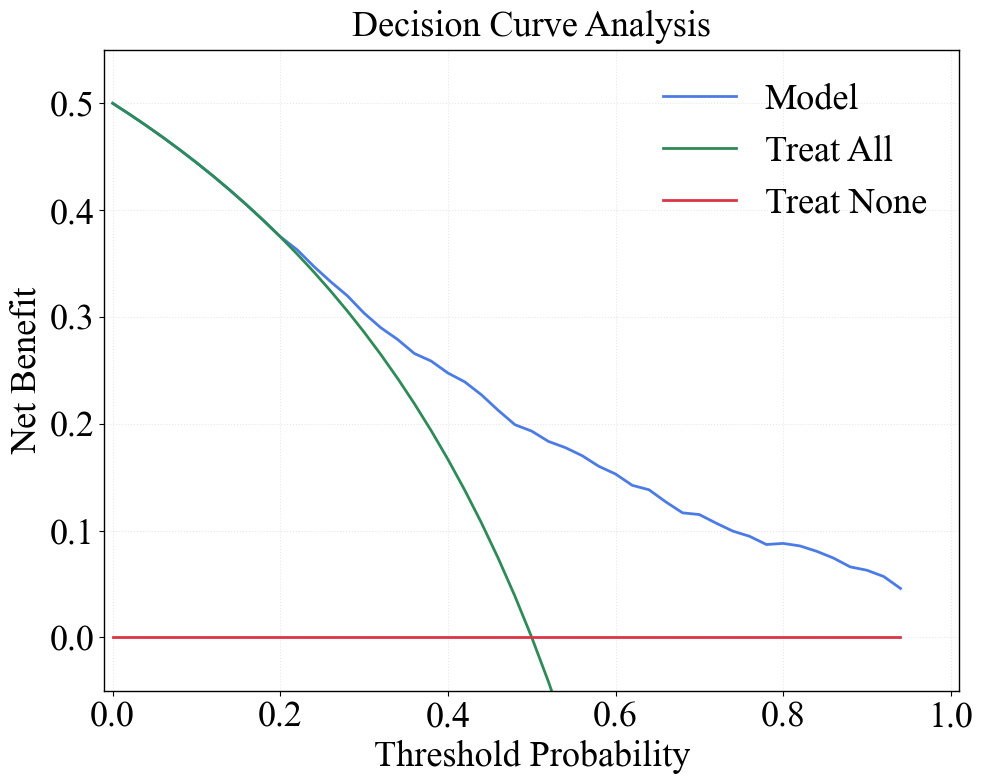

In [15]:
def calculate_net_benefit(threshold, y_true, y_pred_prob):
    # 使用原始未平衡数据计算
    decisions = (y_pred_prob >= threshold).astype(int)
    true_pos = np.sum((decisions == 1) & (y_true == 1))
    false_pos = np.sum((decisions == 1) & (y_true == 0))
    n = len(y_true)
    
    if threshold == 1:
        return 0
    
    return (true_pos - (false_pos * (threshold/(1-threshold)))) / n
def plot_dca(y_true, y_pred_prob):
   # 设置字体和样式
   plt.rcParams.update({
       'font.family': 'Times New Roman',
       'font.size': 12,
       'axes.labelsize': 16,
       'axes.titlesize': 16,
       'xtick.labelsize': 16,
       'ytick.labelsize': 16
   })

   thresholds = np.arange(0, 0.96, 0.02)
   
   net_benefits_model = []
   net_benefits_all = [] 
   net_benefits_none = []
   
   for t in thresholds:
       net_benefits_model.append(calculate_net_benefit(t, y_true, y_pred_prob))
       net_benefits_all.append(calculate_net_benefit(t, y_true, np.ones_like(y_pred_prob)))
       net_benefits_none.append(0)
   
   plt.figure(figsize=(10, 8), dpi=100)
   
   ax = plt.gca()
   ax.set_facecolor('white')
   plt.gcf().set_facecolor('white')
   
   plt.plot(thresholds, net_benefits_model, '-', color='#4B7BE5',
           label='Model', linewidth=2)
   plt.plot(thresholds, net_benefits_all, '-', color='#2E8B57',
           label='Treat All', linewidth=2)
   plt.plot(thresholds, net_benefits_none, '-', color='#DC3445',
           label='Treat None', linewidth=2)
   
   plt.xlim([-0.01, 1.01])
   plt.ylim([-0.05, max(max(net_benefits_model), max(net_benefits_all)) + 0.05])
   
   plt.xlabel('Threshold Probability', fontsize=26, fontfamily='Times New Roman')
   plt.ylabel('Net Benefit', fontsize=26, fontfamily='Times New Roman')
   plt.title('Decision Curve Analysis', pad=10, fontsize=26, fontfamily='Times New Roman')
   
   plt.legend(loc='upper right', fontsize=10, frameon=False, prop={'family': 'Times New Roman'})
   
   for spine in ax.spines.values():
       spine.set_linewidth(1.0)
   
   plt.grid(True, linestyle=':', alpha=0.3)
   plt.xticks(fontsize=26, fontfamily='Times New Roman')
   plt.yticks(fontsize=26, fontfamily='Times New Roman')

   plt.tight_layout()
   
   return plt

y_test_all = np.array(y_test_all)
final_y_pred_prob = np.array(final_y_pred_prob)
plt = plot_dca(y_test_all, final_y_pred_prob)
plt.savefig('dca_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

### RF-CIC曲线图

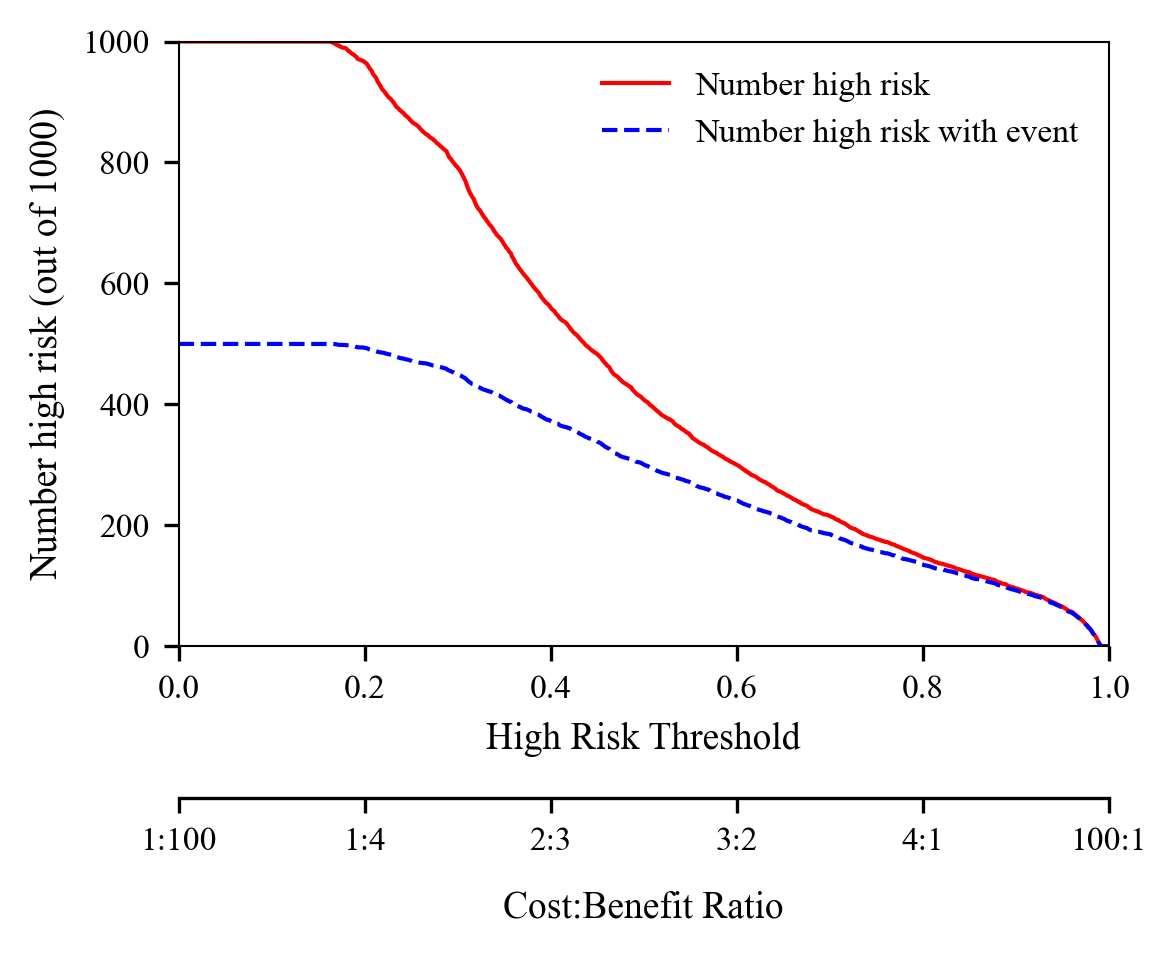

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'

def calculate_metrics_at_threshold(y_true, y_prob, threshold):
    """计算给定阈值下的性能指标"""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    total_samples = len(y_true)
    scaling_factor = 1000 / total_samples
    
    n_high_risk = (fp + tp) * scaling_factor
    n_high_risk_with_event = tp * scaling_factor
    
    return n_high_risk, n_high_risk_with_event

def plot_cost_benefit_curve(y_true, y_prob):
    """绘制成本效益曲线"""
    # 创建更小的图形，底部留出更多空间
    fig, ax = plt.subplots(figsize=(4, 3.2), dpi=300)
    
    # 设置背景色为白色
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # 生成阈值序列
    thresholds = np.linspace(0, 1, 1000)
    
    # 计算指标
    n_high_risk_list = []
    n_high_risk_with_event_list = []
    
    for threshold in thresholds:
        n_high_risk, n_high_risk_with_event = calculate_metrics_at_threshold(
            y_true, y_prob, threshold
        )
        n_high_risk_list.append(n_high_risk)
        n_high_risk_with_event_list.append(n_high_risk_with_event)
    
    # 绘制主曲线，添加标签
    ax.plot(thresholds, n_high_risk_list, color='red', linestyle='-', 
            linewidth=1.0, label='Number high risk')
    ax.plot(thresholds, n_high_risk_with_event_list, color='blue', 
            linestyle='--', linewidth=1.0, label='Number high risk with event')
    
    # 添加图例
    ax.legend(fontsize=8, loc='upper right', frameon=False)
    
    # 设置坐标轴标签，减小字体
    ax.set_xlabel('High Risk Threshold', fontsize=9)
    ax.set_ylabel('Number high risk (out of 1000)', fontsize=9)
    
    # 设置坐标轴范围
    ax.set_ylim(0, 1000)
    ax.set_xlim(0, 1)
    
    # 设置更细的网格线
    #ax.grid(True, linestyle=':', color='gray', alpha=0.2, linewidth=0.3)
    
    # 设置更小的刻度字体
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    # 添加成本效益比例标签
    cost_benefit_ratios = ['1:100', '1:4', '2:3', '3:2', '4:1', '100:1']
    ratio_positions = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    
    # 创建底部x轴
    ax2 = ax.secondary_xaxis(-0.25)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(ratio_positions)
    ax2.set_xticklabels(cost_benefit_ratios, fontsize=8)
    
    # 设置底部标签
    ax2.set_xlabel('Cost:Benefit Ratio', fontsize=9, labelpad=8)
    
    # 设置刻度
    ax2.tick_params(axis='both', which='major', labelsize=8)
    
    # 设置边框
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    
    # 移除ax2的不必要边框
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    
    # 调整边距，为底部轴留出空间
    plt.subplots_adjust(bottom=0.25)
    
    return plt

# 使用模型的真实预测结果
y_true = np.array(y_test_all)
y_prob = np.array(final_y_pred_prob)

# 绘制曲线
plt = plot_cost_benefit_curve(y_true, y_prob)

# 保存更小的图形
plt.savefig('cost_benefit_curve.png', dpi=300, bbox_inches='tight', 
            format='png')
plt.show()

### RF-分组打印评估指标

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import resample

def calculate_metrics(y_true, y_pred, y_prob):
    """计算所有评估指标"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    ppv = precision_score(y_true, y_pred)
    npv = tn / (tn + fn)
    f1 = f1_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, y_prob)
    
    return {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUROC': auroc,
        'PPV': ppv,
        'NPV': npv,
        'F1 Score': f1
    }

def bootstrap_metrics(y_true, y_pred, y_prob, n_iterations=1000):
    """使用bootstrap方法计算指标及其置信区间"""
    metrics_list = []
    n_samples = len(y_true)
    
    for _ in range(n_iterations):
        # Bootstrap采样
        indices = resample(range(n_samples), n_samples=n_samples)
        boot_y_true = y_true[indices]
        boot_y_pred = y_pred[indices]
        boot_y_prob = y_prob[indices]
        
        # 计算当前bootstrap样本的指标
        try:
            tn, fp, fn, tp = confusion_matrix(boot_y_true, boot_y_pred).ravel()
            metrics_list.append({
                'Accuracy': accuracy_score(boot_y_true, boot_y_pred),
                'Sensitivity': recall_score(boot_y_true, boot_y_pred),
                'Specificity': tn / (tn + fp),
                'AUROC': roc_auc_score(boot_y_true, boot_y_prob),
                'PPV': precision_score(boot_y_true, boot_y_pred),
                'NPV': tn / (tn + fn),
                'F1 Score': f1_score(boot_y_true, boot_y_pred)
            })
        except:
            continue
    
    # 计算平均值和置信区间
    results = {}
    metrics_array = np.array([[m[key] for key in metrics_list[0].keys()] for m in metrics_list])
    
    for i, metric_name in enumerate(metrics_list[0].keys()):
        values = metrics_array[:, i]
        mean_val = np.mean(values)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        results[metric_name] = {
            'mean': mean_val,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
    
    return results

def standardize_gender(data):
    """标准化性别编码并删除性别缺失的数据"""
    # 创建性别映射字典
    gender_map = {
        'M': 1, 'F': 0,
        '1': 1, '0': 0,
        1.0: 1, 0.0: 0,
        1: 1, 0: 0
    }
    
    # 确保创建副本避免修改原始数据
    data = data.copy()
    
    # 应用映射转换性别编码
    data['gender'] = data['gender'].map(gender_map)
    
    # 处理可能的空值
    data['gender'] = data['gender'].fillna(-1)
    
    # 打印处理前的样本数
    print(f"\n处理前的样本数: {len(data)}")
    
    # 删除性别为-1的行
    data = data[data['gender'] != -1]
    
    # 打印处理后的样本数和性别分布
    print(f"处理后的样本数: {len(data)}")
    print("\n处理后的性别分布:")
    print(data['gender'].value_counts())
    
    return data

def analyze_subgroups_with_ci(data, y_test_all, final_y_pred, final_y_pred_prob):
    """改进后的子群体分析函数，包含bootstrap置信区间"""
    # 确保输入数据都是numpy数组
    y_test_all = np.array(y_test_all)
    final_y_pred = np.array(final_y_pred)
    final_y_pred_prob = np.array(final_y_pred_prob)
    
    # 1. 数据预处理
    print("\n数据列检查:")
    for column in ['gender', 'age', 'race']:
        print(f"{column} 是否存在: {column in data.columns}")
    
    print("\n数据集中的所有列:")
    print(data.columns.tolist())
    
    print("\n数据对齐前的样本量:")
    print(f"原始数据量: {len(data)}")
    print(f"预测标签量: {len(y_test_all)}")
    
    # 2. 性别编码预处理
    print("\n性别分布（处理前）:")
    if 'gender' in data.columns:
        print(data['gender'].value_counts())
        
        # 标准化性别编码
        data = standardize_gender(data)
        
        print("\n性别分布（处理后）:")
        print(data['gender'].value_counts())
    
    # 获取最短的数组长度
    min_length = min(len(data), len(y_test_all), len(final_y_pred), len(final_y_pred_prob))
    print(f"\n使用的数据长度: {min_length}")
    
    # 截取所有数组到相同长度
    data = data.iloc[:min_length].copy()
    y_test_all = y_test_all[:min_length]
    final_y_pred = final_y_pred[:min_length]
    final_y_pred_prob = final_y_pred_prob[:min_length]
    
    print("\n===== 按性别、年龄段和种族的模型性能分析（含置信区间）=====")
    
    # 1. 性别分组分析
    if 'gender' in data.columns:
        print("\n性别分组分析:")
        for gender_val, gender_label in [(1, '男性'), (0, '女性')]:
            gender_mask = (data['gender'] == gender_val).values
            if np.sum(gender_mask) > 0:
                gender_metrics = bootstrap_metrics(
                    y_test_all[gender_mask],
                    final_y_pred[gender_mask],
                    final_y_pred_prob[gender_mask]
                )
                
                print(f"\n{gender_label}组评估指标 (样本数: {np.sum(gender_mask)}):")
                for metric_name, values in gender_metrics.items():
                    print(f"  {metric_name}: {values['mean']:.4f} "
                          f"(95% CI: [{values['ci_lower']:.4f}, {values['ci_upper']:.4f}])")
    
    # 2. 年龄分组分析
    if 'age' in data.columns:
        print("\n年龄分组分析:")
        age_groups = [
            ((data['age'] >= 65) & (data['age'] < 80), "65-79岁"),
            (data['age'] >= 80, "80岁及以上")
        ]
        
        for age_mask, age_label in age_groups:
            age_mask = age_mask.values
            if np.sum(age_mask) > 0:
                age_metrics = bootstrap_metrics(
                    y_test_all[age_mask],
                    final_y_pred[age_mask],
                    final_y_pred_prob[age_mask]
                )
                
                print(f"\n{age_label}组评估指标 (样本数: {np.sum(age_mask)}):")
                for metric_name, values in age_metrics.items():
                    print(f"  {metric_name}: {values['mean']:.4f} "
                          f"(95% CI: [{values['ci_lower']:.4f}, {values['ci_upper']:.4f}])")
    
    # 3. 种族分组分析
    if 'race' in data.columns:
        print("\n种族分组分析:")
        print("\n数据中的种族类别:")
        print(data['race'].value_counts())
        
        # 定义主要种族类别
        target_races = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'ASIAN', 'HISPANIC OR LATINO']
        
        # 处理种族分类
        other_race_indices = ~data['race'].isin(target_races)
        data.loc[other_race_indices, 'race'] = 'Other'
        
        for race in target_races + ['Other']:
            race_mask = (data['race'] == race).values
            if np.sum(race_mask) > 0:
                race_metrics = bootstrap_metrics(
                    y_test_all[race_mask],
                    final_y_pred[race_mask],
                    final_y_pred_prob[race_mask]
                )
                
                print(f"\n{race}种族组评估指标 (样本数: {np.sum(race_mask)}):")
                for metric_name, values in race_metrics.items():
                    print(f"  {metric_name}: {values['mean']:.4f} "
                          f"(95% CI: [{values['ci_lower']:.4f}, {values['ci_upper']:.4f}])")

# 主程序
if __name__ == "__main__":
    # 调用主函数进行分析
    analyze_subgroups_with_ci(data, y_test_all, final_y_pred, final_y_pred_prob)


数据列检查:
gender 是否存在: True
age 是否存在: True
race 是否存在: True

数据集中的所有列:
['subject_id', 'hadm_id', 'stay_id', 'gender', 'dod', 'admittime', 'dischtime', 'los_hospital', 'age', 'race', 'hospitalid', 'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'icu_intime', 'icu_outtime', 'los_icu_hour', 'icustay_seq', 'first_icu_stay', 'icu_expire_flag', 'icu_survival_days', 'hosp_survival_days', 'icu_time_28d', 'icu_outcome_28d', 'hosp_time_90d', 'hosp_outcome_90d', 'charttime_valuenum', 'e', 'e_unit', 'd', 'd_unit', 'h', 'h_unit', 'f', 'f_unit', 'g', 'g_unit', 'aado2', 'aado2_calc', 'baseexcess', 'bicarbonate', 'calcium', 'carboxyhemoglobin', 'charttime_bg', 'chloride', 'fio2', 'fio2_chartevents', 'glucose', 'hct', 'hemoglobin', 'lactate', 'methemoglobin', 'pao2fio2ratio', 'pco2', 'ph', 'po2', 'potassium', 'rowidx', 'so2', 'sodium', 'temperature', 'totalco2', 'atypical_lymphocytes', 'bands', 'basophils', 'basophils_abs', 'charttime_blood_differential', 'eosinophils', 'eosinophils_abs', 'imma

### RF-分组绘画评估指标

Group 1 vs Group 2: p = 0.0001
Group 3 vs Group 4: p = 0.0008
Group 5 vs Group 6: p = 0.0000
Group 7 vs Group 8: p = 0.0000


C:\Users\MECHREV\AppData\Local\Temp\ipykernel_31680\4203443601.py:51: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (mean1 - mean2) / np.sqrt(se1**2 + se2**2)


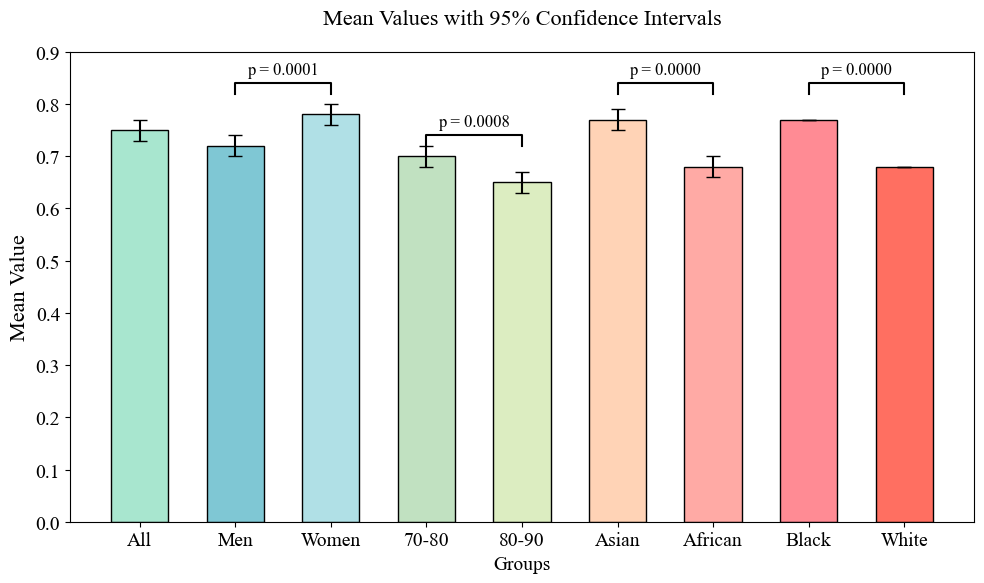

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t 
# 数据
groups = ['All', 'Men', 'Women', '70-80', '80-90', 'Asian', 'African','Black','White']
means = [0.75, 0.72, 0.78, 0.70, 0.65, 0.77, 0.68, 0.77, 0.68]  # 平均值
ci_lower = [0.73, 0.70, 0.76, 0.68, 0.63, 0.75, 0.66, 0.77, 0.68]  # 置信区间下限
ci_upper = [0.77, 0.74, 0.80, 0.72, 0.67, 0.79, 0.70, 0.77, 0.68]  # 置信区间上限

# 自定义颜色，按组设置色系
colors = [
    '#A8E6CF',  # All (浅绿色)
    '#7FC7D4', '#B0E0E6',  # Men, Women (浅蓝色系)
    '#C1E1C1', '#DCEDC1',  # 70-80, 80-90 (浅绿色系)
    '#FFD3B6', '#FFAAA5', '#FF8B94', '#FF6F61'  # Asian, African, Black, White (浅红色/橙色系)
]

# 计算误差条的高度
ci_lower_error = [means[i] - ci_lower[i] for i in range(len(means))]
ci_upper_error = [ci_upper[i] - means[i] for i in range(len(means))]
error = [ci_lower_error, ci_upper_error]

# 创建柱状图
plt.figure(figsize=(10, 6))
bars = plt.bar(groups, means, yerr=error, capsize=5, color=colors, edgecolor='black',width=0.6)

# 添加数值标签
# for bar in bars:
#     height = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
#              ha='center', va='bottom', fontsize=12)

# 设置标题和标签
plt.title('Mean Values with 95% Confidence Intervals', fontsize=16, pad=20)
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Mean Value', fontsize=16)

# 设置刻度标签字体大小
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# 设置 y 轴范围
plt.ylim(0, 0.9)

# 计算显著性 p 值并标注在图上
def calculate_and_annotate_p_value(mean1, mean2, ci_lower1, ci_upper1, ci_lower2, ci_upper2, x1, x2, y_max):
    # 计算标准误差
    se1 = (ci_upper1 - ci_lower1) / (2 * 1.96)  # 95% 置信区间对应的标准误差
    se2 = (ci_upper2 - ci_lower2) / (2 * 1.96)
    
    # 计算 t 统计量和 p 值
    t_stat = (mean1 - mean2) / np.sqrt(se1**2 + se2**2)
    p_value = 2 * (1 - t.cdf(abs(t_stat), df=100))  # 假设样本量为 100
    
    print(f'Group {x1} vs Group {x2}: p = {p_value:.4f}')
    
    # 在图上标注 p 值
    plt.plot([x1, x1, x2, x2], [y_max, y_max + 0.02, y_max + 0.02, y_max], lw=1.5, color='black')
    plt.text((x1 + x2) * 0.5, y_max + 0.03, f'p = {p_value:.4f}', ha='center', va='bottom', fontsize=12)

# 标注显著性 p 值
calculate_and_annotate_p_value(means[1], means[2], ci_lower[1], ci_upper[1], ci_lower[2], ci_upper[2], 1, 2, 0.82)  # Men vs Women
calculate_and_annotate_p_value(means[3], means[4], ci_lower[3], ci_upper[3], ci_lower[4], ci_upper[4], 3, 4, 0.72)  # 70-80 vs 80-90
calculate_and_annotate_p_value(means[5], means[6], ci_lower[5], ci_upper[5], ci_lower[6], ci_upper[6], 5, 6, 0.82)  # Asian vs African
calculate_and_annotate_p_value(means[7], means[8], ci_lower[7], ci_upper[7], ci_lower[8], ci_upper[8], 7, 8, 0.82)  # Black vs White


# 显示图形
plt.tight_layout()
plt.show()

In [19]:
import numpy as np
from scipy.stats import t

# 数据
data = np.array([0.6849, 0.6841, 0.6849, 0.6812, 0.6829, 0.6489])

# 样本均值
mean = np.mean(data)

# 样本标准差
std_dev = np.std(data, ddof=1)

# 样本大小
n = len(data)

# 标准误差
std_error = std_dev / np.sqrt(n)

# t 分布临界值 (95% 置信区间，自由度 = n-1)
t_critical = t.ppf(0.975, df=n-1)

# 置信区间
margin_of_error = t_critical * std_error
ci_lower = mean - margin_of_error
ci_upper = mean + margin_of_error

print(f"Mean: {mean:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


Mean: 0.6778
95% Confidence Interval: [0.6629, 0.6928]


### 所有模型评估指标

In [20]:
# 导入所需的库
import optuna
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                           precision_score, recall_score, f1_score)
import numpy as np

# XGBoost模型选择的特征和超参数
# best_params: {'n_estimators': 201, 'max_depth': 9, 'learning_rate': 0.1335376701461377, 'min_child_weight': 6, 
# 'gamma': 0.21064265390797143, 'subsample': 0.895162492770872, 'colsample_bytree': 0.7272554168734067, 
# 'scale_pos_weight': 1.1277357372234167, 'reg_alpha': 0.5503700132271422, 'reg_lambda': 0.6075194736990024}
# Selected features: ['age' 'aniongap' 'bun' 'creatinine' 'wbc' 'rbc' 'weight'
#  'hr' 'rr' 'temperature' 'glucose' 'gcs']
# Number of selected features: 12


def objective_xgboost(trial):
    # 使用注释中给出的最佳参数
    params = {
        'n_estimators': 201,
        'max_depth': 9,
        'learning_rate': 0.1335376701461377,
        'min_child_weight': 6,
        'gamma': 0.21064265390797143,
        'subsample': 0.895162492770872,
        'colsample_bytree': 0.7272554168734067,
        'scale_pos_weight': 1.1277357372234167,
        'reg_alpha': 0.5503700132271422,
        'reg_lambda': 0.6075194736990024,
        'random_state': 42
    }
#     Selected_features = ['aniongap', 'bun', 'creatinine', 'wbc', 'mchc', 'rdw', 'rbc', 'hr', 'sbp',
#   'dbp', 'mbp', 'rr', 'temperature', 'glucose', 'gcs']
    Selected_features =['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']
    return params, Selected_features
    #return np.mean(cross_val_score(model, X_train_pls, y_train_fold, cv=5, scoring='roc_auc'))

# # lightgbm模型选择的特征和超参数
# best_params: {'learning_rate': 0.047669762018487424, 'n_estimators': 79, 'num_leaves': 45, 'max_depth': 7, 
# 'min_child_samples': 7, 'feature_fraction': 0.8057018384484658, 'bagging_fraction': 0.706785747058316}
# Selected features: ['age' 'aniongap' 'bun' 'creatinine' 'wbc' 'rbc' 'hr'
#  'rr' 'temperature' 'glucose' 'gcs']
# Number of selected features: 11

def objective_lightgbm(trial):
    # 使用注释中给出的最佳参数
    params = {
        'learning_rate': 0.047669762018487424,
        'n_estimators': 79,
        'num_leaves': 45,
        'max_depth': 7,
        'min_child_samples': 7,
        'feature_fraction': 0.8057018384484658,
        'bagging_fraction': 0.706785747058316,
        'random_state': 42
    }
    # Selected_features = ['aniongap', 'bun', 'creatinine', 'wbc', 'mchc', 'hr', 'sbp', 
    #                     'dbp', 'mbp', 'rr', 'temperature', 'glucose', 'gcs']
    Selected_features =['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']
    return params, Selected_features
    #return np.mean(cross_val_score(model, X_train_pls, y_train_fold, cv=5, scoring='roc_auc'))


# # RF模型选择的特征和超参数
# best_params: {'n_estimators': 141, 'max_depth': 9, 
#               'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'log2'}
# Selected features: ['age' 'aniongap' 'bun' 'creatinine' 'wbc' 'rbc' 'weight'
#  'hr' 'rr' 'temperature' 'glucose' 'gcs']
# Number of selected features: 12


def objective_random_forest(trial):
    # 使用注释中给出的最佳参数
    params = {
        'n_estimators': 141,
        'max_depth': 9,
        'min_samples_split': 10,
        'min_samples_leaf': 6,
        'max_features': 'log2',
        'random_state': 42
    }
    Selected_features = ['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']

    return params, Selected_features
    #return np.mean(cross_val_score(model, X_train_pls, y_train_fold, cv=5, scoring='roc_auc'))


# # SVM模型选择的特征和超参数
# best_params: {'C': 3.8606754376312318}
# Selected features: ['age' 'aniongap' 'bun' 'creatinine' 'wbc' 'rbc' 'weight'
#  'hr' 'rr' 'temperature' 'glucose' 'gcs']
# Number of selected features: 12
def objective_svm(trial):
    params = {
        'C': 3.8606754376312318,
        'gamma': 'scale',
        'kernel': 'rbf',
        'probability': True,
        'random_state': 42,
        'cache_size': 1000
    }
    Selected_features = ['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']

    return params, Selected_features
    #return np.mean(cross_val_score(model, X_train_pls, y_train_fold, cv=5, scoring='roc_auc'))



# # AdaBoost模型选择的特征和超参数
# best_params: {'n_estimators': 177, 'learning_rate': 0.420580705420142}
# Selected features: ['aniongap' 'bun' 'creatinine' 'wbc' 'rbc' 'hr' 'rr'
#  'temperature' 'glucose' 'gcs']
# # Number of selected features: 10
def objective_adaboost(trial):
    params = {
        'n_estimators': 177,
        'learning_rate': 0.420580705420142,
        'random_state': 42
    }
    Selected_features = ['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']
    return params, Selected_features
    #return np.mean(cross_val_score(model, X_train_pls, y_train_fold, cv=5, scoring='roc_auc'))


# # LR模型选择的特征和超参数
# best_params: {'C': 2.195022414600841, 'penalty': 'l1', 'solver': 'liblinear'}
# Selected features: ['age' 'aniongap' 'bun' 'creatinine' 'wbc' 'rbc' 'hr'
#  'rr' 'temperature' 'glucose' 'gcs']
# Number of selected features: 11
def objective_logistic(trial):
    params = {
        'C': 1.9351172214826404,
        'penalty': 'l2',
        'solver': 'liblinear',
        'max_iter': 500,
        'random_state': 42
    }
    Selected_features = ['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']

    return params, Selected_features
    #return np.mean(cross_val_score(model, X_train_pls, y_train_fold, cv=5, scoring='roc_auc'))



def calculate_metrics(y_true, y_pred, y_prob):
    """计算所有评估指标"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    ppv = precision_score(y_true, y_pred)
    npv = tn / (tn + fn)
    f1 = f1_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, y_prob)
    
    return {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUROC': auroc,
        'PPV': ppv,
        'NPV': npv,
        'F1 Score': f1
    }

# 获取每个模型的参数和特征
xgb_params, xgb_features = objective_xgboost(None)
lgb_params, lgb_features = objective_lightgbm(None)
rf_params, rf_features = objective_random_forest(None)
svm_params, svm_features = objective_svm(None)
ada_params, ada_features = objective_adaboost(None)
lr_params, lr_features = objective_logistic(None)
#dt_params, dt_features = objective_dt(None)



# 使用优化后的参数定义模型
models = {
    'XGBoost': {'model': XGBClassifier(**xgb_params), 'features': xgb_features},
    'LightGBM': {'model': LGBMClassifier(**lgb_params), 'features': lgb_features},
    'AdaBoost': {'model': AdaBoostClassifier(**ada_params), 'features': ada_features},
    'RandomForest': {'model': RandomForestClassifier(**rf_params), 'features': rf_features},
    'SVM': {'model': SVC(**svm_params), 'features': svm_features},
    'LogisticRegression': {'model': LogisticRegression(**lr_params), 'features': lr_features},
    #'DT': {'model': DecisionTreeClassifier(**dt_params), 'features': dt_features}
}

model_name = ['XGBoost','LightGBM','RandomForest','AdaBoost','SVM','AdaBoost','LogisticRegression']

# 创建字典来存储所有模型的评估指标
all_models_metrics = {model_name: {
    'train_metrics': [],
    'test_metrics': []
} for model_name in models.keys()}

# 定义计算均值和置信区间的函数
def compute_mean_and_ci(results, metric_idx):
    metrics = np.array([result[metric_idx] for result in results])
    mean = np.mean(metrics)
    ci = 1.96 * np.std(metrics) / np.sqrt(len(metrics))  # 95% 置信区间
    return mean, ci

# 定义评估指标列表
metrics = ['Train Accuracy', 'Test Accuracy', 'Train Sensitivity', 'Test Sensitivity', 
          'Train Specificity', 'Test Specificity', 'Train AUROC', 'Test AUROC', 
          'Train PPV', 'Test PPV', 'Train NPV', 'Test NPV', 'Train F1 Score', 'Test F1 Score']

# 创建字典来存储所有模型的评估指标
all_models_metrics = {model_name: {
    'train_metrics': [],
    'test_metrics': []
} for model_name in models.keys()}

# 对每个模型进行训练和评估
for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")
    model = model_info['model']
    features = model_info['features']
    
    # 检查特征是否存在
    available_features = []
    missing_features = []
    for feature in features:
        if feature in X_final.columns:
            available_features.append(feature)
        else:
            missing_features.append(feature)
    
    if missing_features:
        print(f"Warning: Following features are missing for {model_name}: {missing_features}")
        print(f"Will proceed with available features: {available_features}")
        features = available_features
    
    # 为每个模型重置结果存储
    final_fold_results = []
    y_test_all = []
    y_test_pred_all = []
    final_y_pred_prob = []
    
    # 使用选定的特征创建数据子集
    X_selected = X_final[features]
    
    print("Available features in dataset:")
    print(X_final.columns.tolist())
    
    # Repeated Stratified K-Fold
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    for fold_idx, (train_index, test_index) in enumerate(rskf.split(X_selected, labels, gender_labels)):
        print(f"\nFold {fold_idx + 1}:")
        
        X_train_fold_orig = X_selected.iloc[train_index]
        X_test_fold = X_selected.iloc[test_index]
        y_train_fold_orig = labels.iloc[train_index]
        y_test_fold = labels.iloc[test_index]
        
        # 平衡训练集和测试集
        X_train_fold, y_train_fold = balance_samples(X_train_fold_orig, y_train_fold_orig)
        X_test_fold, y_test_fold = balance_samples(X_test_fold, y_test_fold)
        
        # 输出当前折的训练集和测试集正负样本数量
        print("Training set - Positive samples:", sum(y_train_fold == 1), ", Negative samples:", sum(y_train_fold == 0))
        print("Testing set - Positive samples:", sum(y_test_fold == 1), ", Negative samples:", sum(y_test_fold == 0))
        
        # 打印当前折使用的特征
        print("\nFeatures used in this fold:")
        for i, feature in enumerate(X_train_fold.columns, 1):
            print(f"{i}. {feature}")
        print("-" * 50)
        
        # 训练模型并评估
        final_results = evaluate_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
        final_fold_results.append(final_results)
        
        # 收集预测结果
        y_test_all.extend(y_test_fold)
        if isinstance(model, SVC):
            y_test_prob = model.decision_function(X_test_fold)
            y_test_prob = 1 / (1 + np.exp(-y_test_prob))
        else:
            y_test_prob = model.predict_proba(X_test_fold)[:, 1]
        final_y_pred_prob.extend(y_test_prob)
    
    # 输出最终的长度检查
    print(f"\nTotal true labels: {len(y_test_all)}")
    print(f"Total predicted probabilities: {len(final_y_pred_prob)}")
    
    # 打印每一折的评估结果
    for idx, result in enumerate(final_fold_results, 1):
        train_acc, test_acc, train_sens, test_sens, train_spec, test_spec, train_auroc, test_auroc, train_ppv, test_ppv, train_npv, test_npv, train_f1, test_f1, y_test, y_test_pred, model = result
        print(f"\nFold {idx} evaluation metrics after refitting:")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Train Sensitivity: {train_sens:.4f}")
        print(f"  Test Sensitivity: {test_sens:.4f}")
        print(f"  Train Specificity: {train_spec:.4f}")
        print(f"  Test Specificity: {test_spec:.4f}")
        print(f"  Train AUROC: {train_auroc:.4f}")
        print(f"  Test AUROC: {test_auroc:.4f}")
        print(f"  Train PPV: {train_ppv:.4f}")
        print(f"  Test PPV: {test_ppv:.4f}")
        print(f"  Train NPV: {train_npv:.4f}")
        print(f"  Test NPV: {test_npv:.4f}")
        print(f"  Train F1: {train_f1:.4f}")
        print(f"  Test F1: {test_f1:.4f}")
    
    # 存储该模型的结果
    all_models_metrics[model_name] = {
        'final_fold_results': final_fold_results,
        'y_test_all': y_test_all,
        'final_y_pred_prob': final_y_pred_prob
    }

# 打印所有模型的比较结果
print("\nModel Comparison:")
for model_name in models.keys():
    results = all_models_metrics[model_name]['final_fold_results']
    print(f"\n{model_name}:")
    for idx, metric in enumerate(metrics):
        mean, ci = compute_mean_and_ci(results, idx)
        print(f'{metric}: Mean = {mean:.3f}, 95% CI = [{mean-ci:.3f}, {mean+ci:.3f}]')




Training XGBoost...
Available features in dataset:
['creatinine', 'gcs', 'hr', 'aniongap', 'wbc', 'rr']

Fold 1:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 872 , Negative samples: 872

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------


d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(



Fold 2:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 3:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 4:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 5:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6

d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8057018384484658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8057018384484658
[LightGBM] [Warning] bagging_fraction is set=0.706785747058316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.706785747058316
[LightGBM] [Warning] feature_fraction is set=0.8057018384484658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8057018384484658
[LightGBM] [Warning] bagging_fraction is set=0.706785747058316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.706785747058316
[LightGBM] [Warning] feature_fraction is set=0.8057018384484658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8057018384484658
[LightGBM] [Warning] bagging_fraction is set=0.706785747058316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.706785747058316
[LightGBM] [Warning] feature_fraction is set=0.8057018384484658, colsample_bytree=1.0 will be ignored. 

d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(



Fold 2:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 3:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 4:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 5:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6

d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(



Fold 2:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 3:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 4:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 5:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6

d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(



Fold 2:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 3:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 4:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6. rr
--------------------------------------------------

Fold 5:
Training set - Positive samples: 3486 , Negative samples: 3486
Testing set - Positive samples: 871 , Negative samples: 871

Features used in this fold:
1. creatinine
2. gcs
3. hr
4. aniongap
5. wbc
6

d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:86: UserWarning: The groups parameter is ignored by RepeatedStratifiedKFold
  warnings.warn(
d:\Anaconda3\envs\zss\lib\site-packages\sklearn\model_selection\_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


### 所有模型ROC图

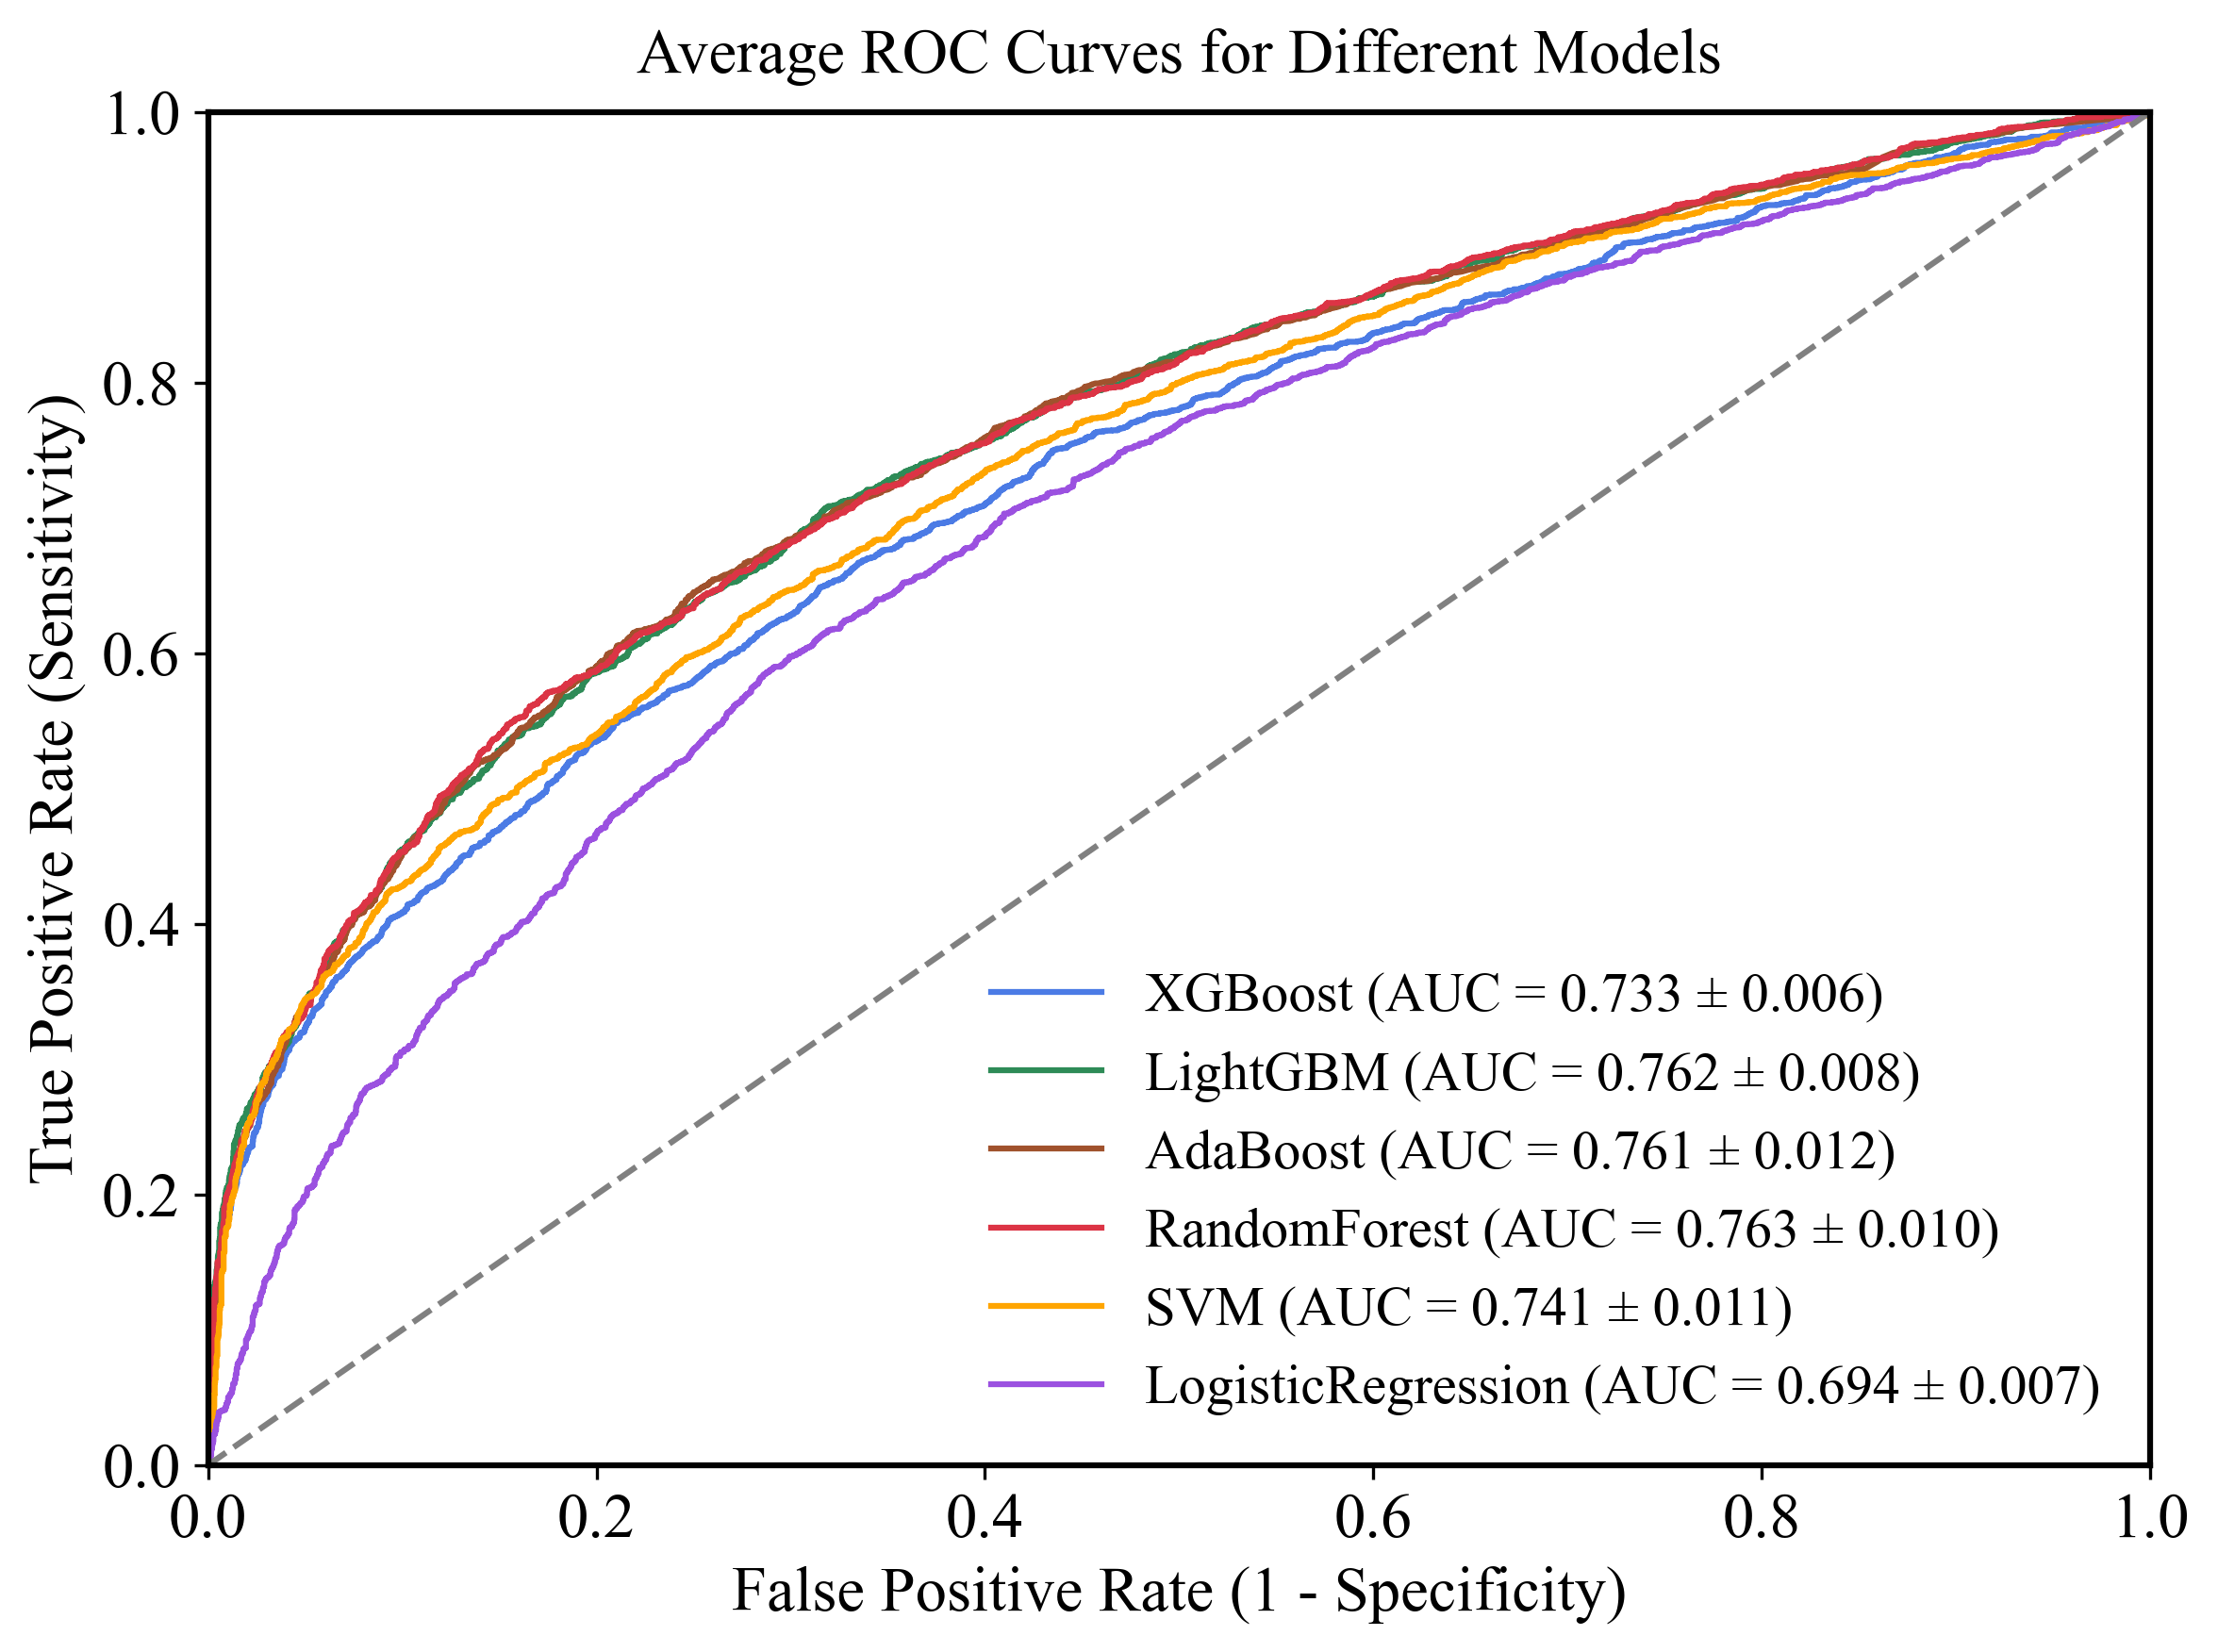

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_roc_curves(models, all_models_metrics):
   # 设置全局字体
   plt.rcParams.update({
       'font.family': 'Times New Roman',
       'font.serif': ['Times New Roman'],
       'font.size': 12,
       'axes.labelsize': 16, 
       'axes.titlesize': 16,
       'xtick.labelsize': 16,
       'ytick.labelsize': 16,
       'legend.fontsize': 14
   })

   plt.figure(figsize=(8, 6), dpi=300)

   colors = {
       'XGBoost': '#4B7BE5',
       'LightGBM': '#2E8B57',
       'RandomForest': '#DC3445',
        'AdaBoost': '#A0522D',
        'SVM': '#FFA500',
       'LogisticRegression': '#9B51E0', 
   }

   # 计算AUC
   model_aucs = {}
   for model_name in models.keys():
       results = all_models_metrics[model_name]['final_fold_results']
       test_aurocs = [result[7] for result in results]
       mean_auc = np.mean(test_aurocs)
       std_auc = np.std(test_aurocs)
       model_aucs[model_name] = (mean_auc, std_auc)

   ax = plt.gca()
   ax.set_facecolor('white')
   plt.gcf().set_facecolor('white')

   for model_name in models.keys():
       y_test = all_models_metrics[model_name]['y_test_all']
       y_pred_prob = all_models_metrics[model_name]['final_y_pred_prob']
       
       fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
       mean_auc, std_auc = model_aucs[model_name]
       
       plt.plot(fpr, tpr,
                color=colors[model_name],
                label=f'{model_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})',
                linewidth=1.5)

   plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.5)
   plt.xlim([0, 1])
   plt.ylim([0, 1])

   plt.xlabel('False Positive Rate (1 - Specificity)', fontfamily='Times New Roman')
   plt.ylabel('True Positive Rate (Sensitivity)', fontfamily='Times New Roman')
   plt.title('Average ROC Curves for Different Models', fontfamily='Times New Roman', pad=10)

   plt.legend(loc="lower right",
             prop={'family': 'Times New Roman'},
             frameon=False,
             edgecolor='black')

   plt.xticks(fontfamily='Times New Roman')
   plt.yticks(fontfamily='Times New Roman')

   for spine in ax.spines.values():
       spine.set_linewidth(1.5)

   #plt.grid(True, linestyle=':', alpha=0.3)
   plt.tight_layout()
   return plt

plt = plot_roc_curves(models, all_models_metrics)  
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### 所有模型混淆矩阵图

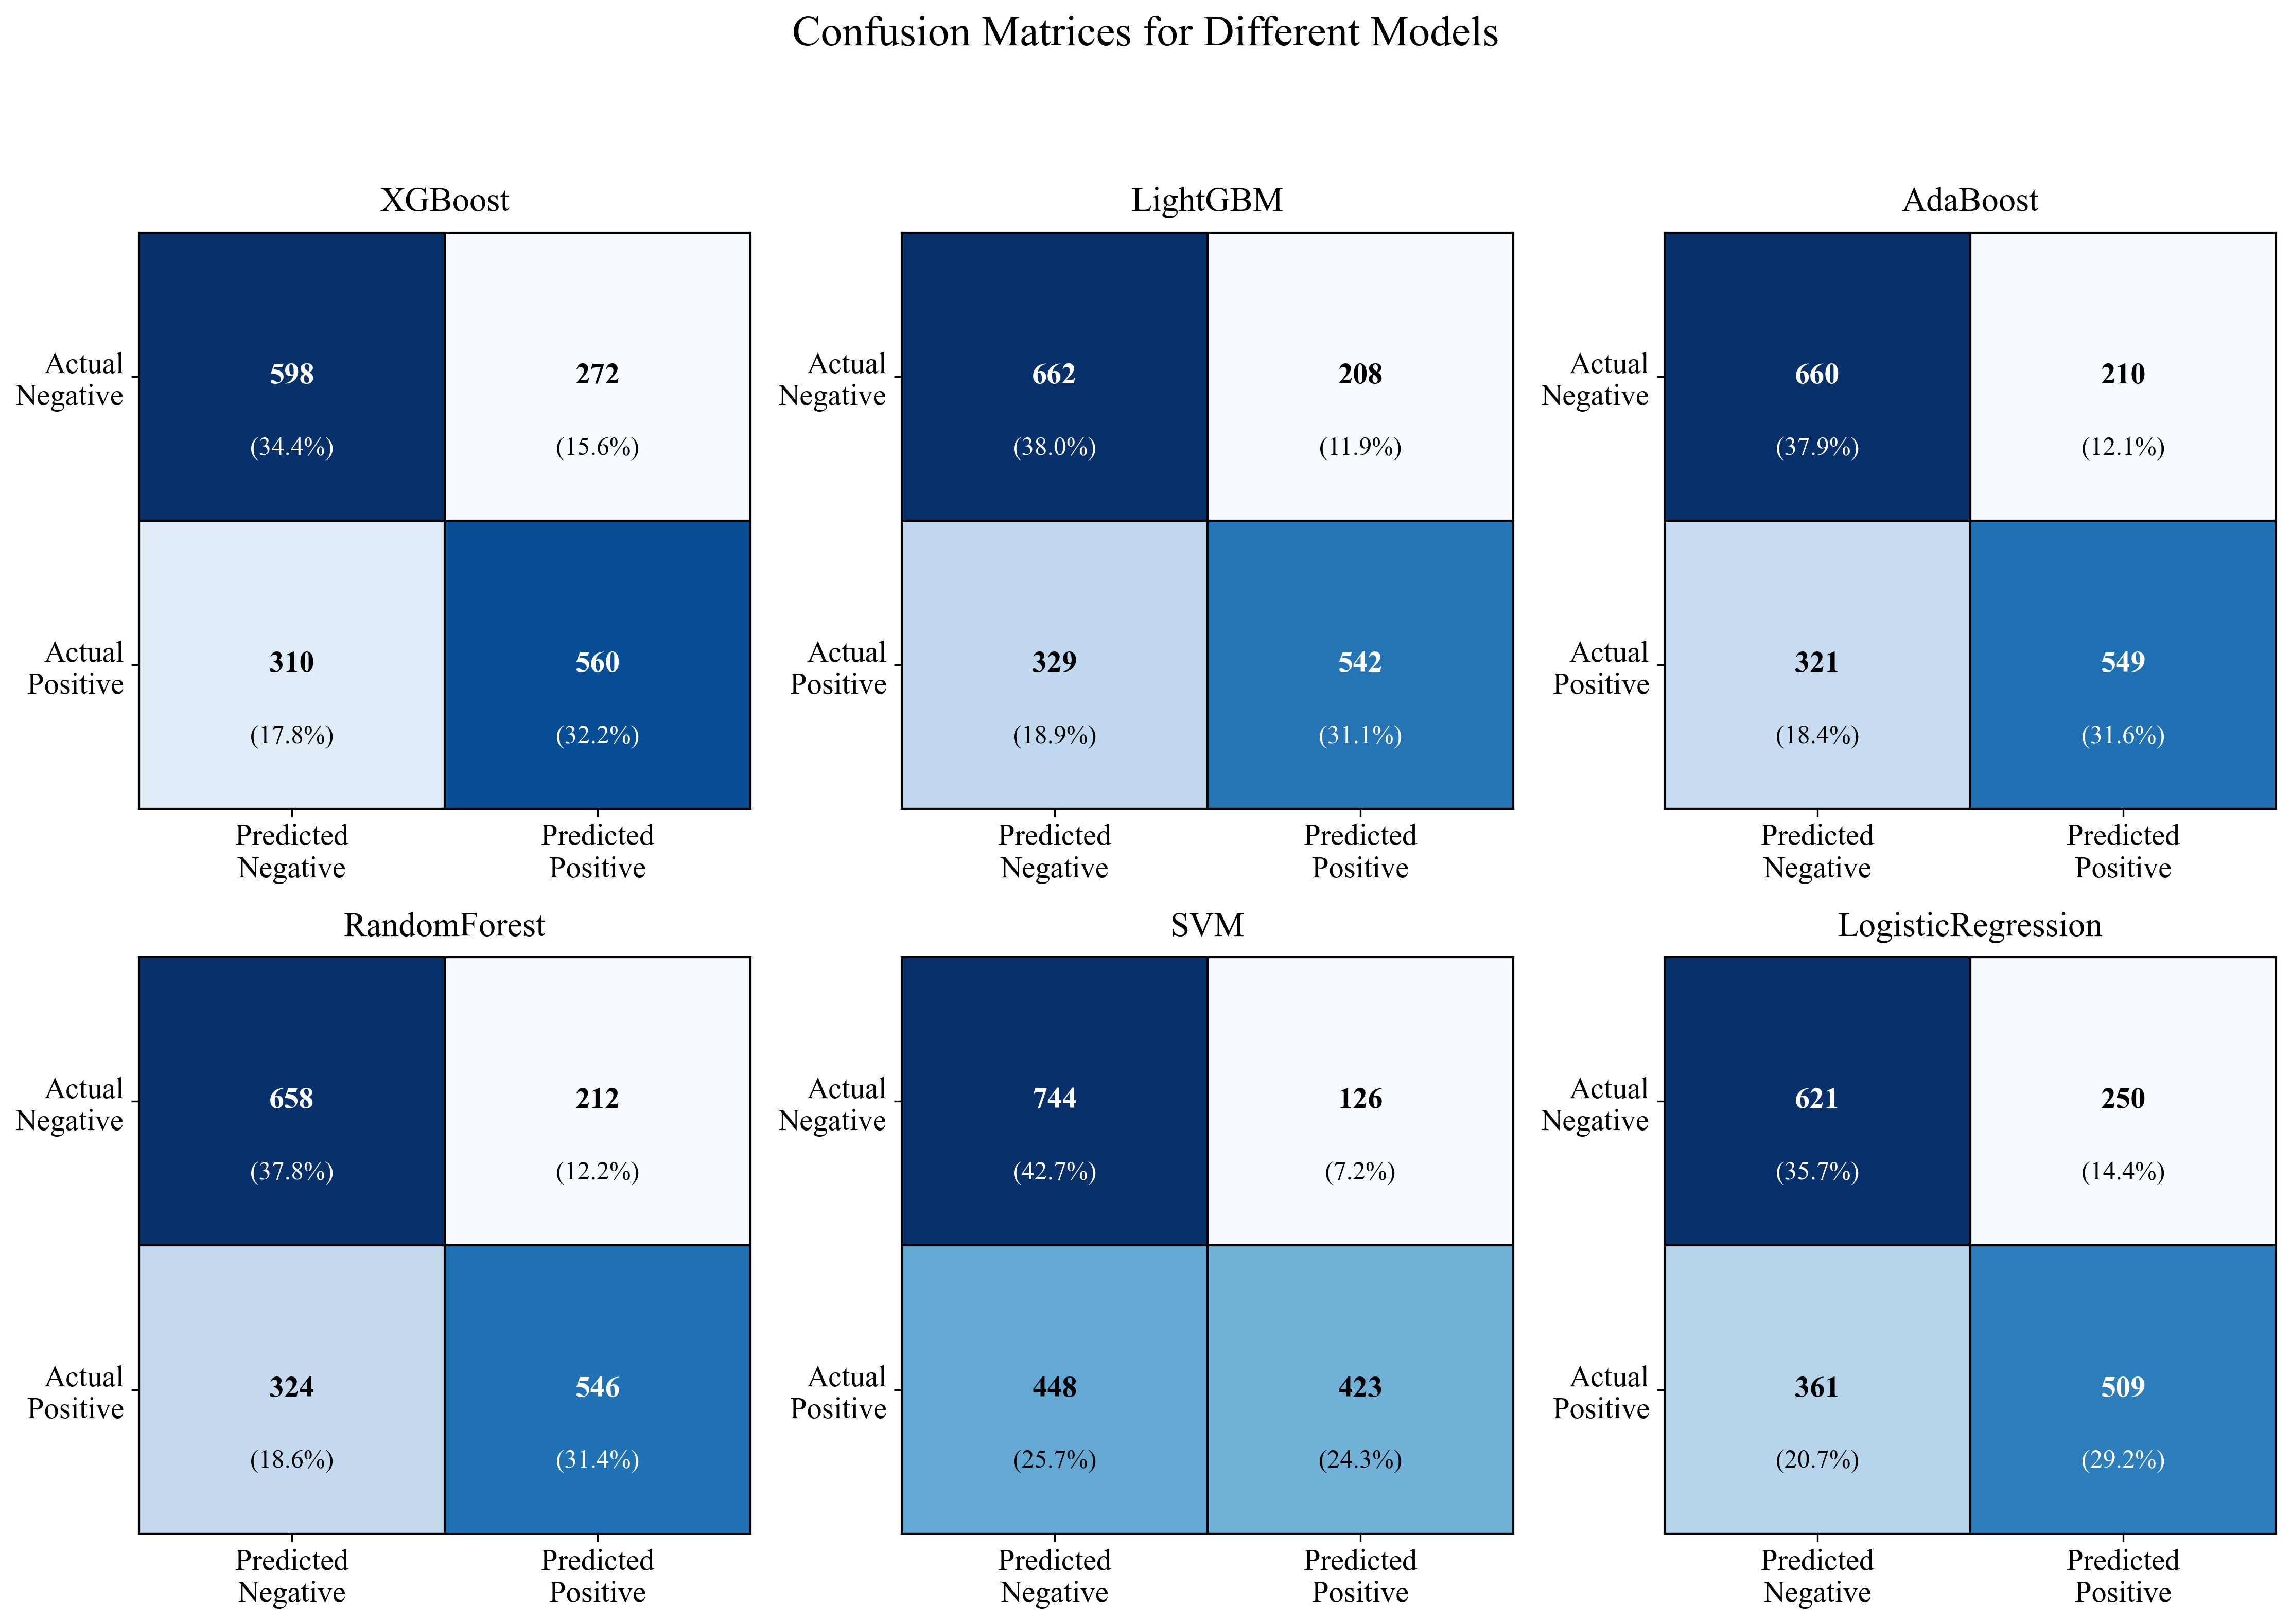

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(all_models_metrics):
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'font.serif': ['Times New Roman'],
        'font.size': 12,
        'axes.labelsize': 16,
        'axes.titlesize': 16,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 14
    })

    fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
    fig.suptitle('Confusion Matrices for Different Models', 
                 fontsize=20, 
                 y=1.05, 
                 fontfamily='Times New Roman')

    cmap = plt.cm.Blues

    for idx, (model_name, metrics) in enumerate(all_models_metrics.items()):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        ax.set_facecolor('white')
        
        # 从metrics中获取真实标签和预测概率
        y_true = np.array(metrics['y_test_all'])
        y_pred_prob = np.array(metrics['final_y_pred_prob'])
        fold_size = len(y_true) // 5
        
        cm_sum = np.zeros((2, 2))
        
        for i in range(5):
            start_idx = i * fold_size
            end_idx = (i + 1) * fold_size if i < 4 else len(y_true)
            fold_y_true = y_true[start_idx:end_idx]
            fold_y_pred = (y_pred_prob[start_idx:end_idx] > 0.5).astype(int)
            cm = confusion_matrix(fold_y_true, fold_y_pred)
            cm_sum += cm
        
        cm = (cm_sum / 5).astype(int)
        total = cm.sum()
        cm_percent = cm / total * 100
        cm_norm = cm.astype('float') / cm.max()
        
        im = ax.imshow(cm_norm, interpolation='nearest', 
                      cmap=cmap,
                      aspect='auto')
        
        # 修改这里：对于浅色背景使用黑色文字，深色背景使用白色文字
        for i in range(2):
            for j in range(2):
                # 调整阈值，使得浅色区域都使用黑色文字
                color = "white" if cm_norm[i, j] > 0.7 else "black"
                # 显示数值
                ax.text(j, i, str(cm[i, j]),
                       ha="center", va="center",
                       color=color,
                       fontsize=14,
                       fontfamily='Times New Roman',
                       fontweight='bold')
                # 显示百分比
                ax.text(j, i + 0.25,
                       f'({cm_percent[i,j]:.1f}%)',
                       ha='center', 
                       va='center',
                       color=color,
                       fontsize=12,
                       fontfamily='Times New Roman')
        
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Predicted\nNegative', 'Predicted\nPositive'],
                          fontfamily='Times New Roman', 
                          fontsize=14)
        ax.set_yticklabels(['Actual\nNegative', 'Actual\nPositive'],
                          fontfamily='Times New Roman', 
                          fontsize=14)
        
        ax.set_title(f'{model_name}', 
                    pad=10, 
                    fontsize=16, 
                    fontfamily='Times New Roman')
        
        for spine in ax.spines.values():
            spine.set_linewidth(1.0)
            
        ax.set_xticks(np.arange(-0.5, 2, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 2, 1), minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", size=0)

    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    
    return plt

# 使用示例:
plt = plot_confusion_matrices(all_models_metrics)
plt.show()

### 所有模型DCA决策曲线图

C:\Users\MECHREV\AppData\Local\Temp\ipykernel_31680\142083334.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  net_benefit = (TP/n) - (FP/n) * (threshold/(1-threshold))


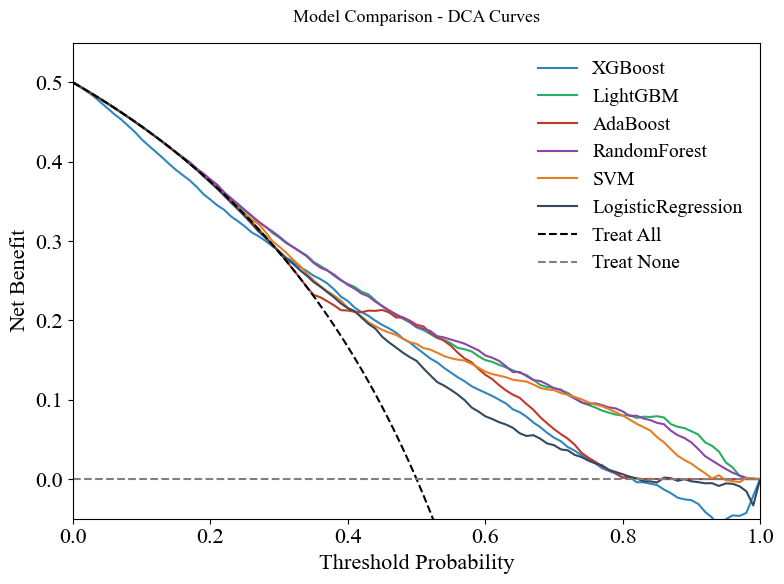

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dca_curves(all_models_metrics, title="Model Comparison - DCA Curves"):
    plt.figure(figsize=(8, 6))
    # plt.rcParams['font.family'] = 'Times New Roman'
    # plt.rcParams['axes.linewidth'] = 1.5

    # 设置全局字体
    plt.rcParams.update({
       'font.family': 'Times New Roman',
       'font.serif': ['Times New Roman'],
       'font.size': 12,
       'axes.labelsize': 16, 
       'axes.titlesize': 16,
       'xtick.labelsize': 16,
       'ytick.labelsize': 16,
       'legend.fontsize': 14
   })
    # 设置颜色映射
    colors = {
        'XGBoost': '#2E86C1',
        'LightGBM': '#27AE60',
        'RandomForest': '#8E44AD',
        'SVM': '#E67E22',
        'AdaBoost': '#C0392B',
        'LogisticRegression': '#34495E'
    }
    
    # 计算阈值范围
    thresholds = np.arange(0, 1.01, 0.01)
    
    # 绘制每个模型的DCA曲线
    for model_name, metrics in all_models_metrics.items():
        y_true = np.array(metrics['y_test_all'])
        y_pred_prob = np.array(metrics['final_y_pred_prob'])
        
        # 确保长度一致
        min_len = min(len(y_true), len(y_pred_prob))
        y_true = y_true[:min_len]
        y_pred_prob = y_pred_prob[:min_len]
        
        # 计算净收益
        net_benefits = []
        for threshold in thresholds:
            y_pred = (y_pred_prob >= threshold).astype(int)
            TP = np.sum((y_true == 1) & (y_pred == 1))
            FP = np.sum((y_true == 0) & (y_pred == 1))
            n = len(y_true)
            
            if TP + FP == 0:
                net_benefit = 0
            else:
                net_benefit = (TP/n) - (FP/n) * (threshold/(1-threshold))
            net_benefits.append(net_benefit)
            
        plt.plot(thresholds, net_benefits, '-', color=colors[model_name], 
                linewidth=1.5, label=model_name)
    
    # 绘制"全部治疗"和"无人治疗"的基线
    all_positives = np.ones_like(y_true)
    net_benefits_all = []
    for threshold in thresholds:
        TP = np.sum(y_true == 1)
        FP = np.sum(y_true == 0)
        n = len(y_true)
        net_benefit = (TP/n) - (FP/n) * (threshold/(1-threshold))
        net_benefits_all.append(net_benefit)
    
    plt.plot(thresholds, net_benefits_all, '--', color='black', 
            linewidth=1.5, label='Treat All')
    plt.plot(thresholds, np.zeros_like(thresholds), '--', color='gray', 
            linewidth=1.5, label='Treat None')
    
    plt.xlabel('Threshold Probability', fontsize=16)
    plt.ylabel('Net Benefit', fontsize=16)
    plt.title(title, fontsize=13, pad=15)

    plt.tick_params(axis='x', labelsize=16)
    # 如果也需要设置y轴刻度标签的字体大小，可以这样做：
    plt.tick_params(axis='y', labelsize=16)


    #plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(loc='upper right', frameon=False, facecolor='white', 
              edgecolor='black', fontsize=14)
    
    plt.xlim(0, 1)
    plt.ylim(min(min(net_benefits), -0.05), 
             max(max(net_benefits_all), max(net_benefits)) + 0.05)
    
    plt.tight_layout()
    return plt.gcf()

    for spine in ax.spines.values():
       spine.set_linewidth(1.5)
# 使用示例：
plot_dca_curves(all_models_metrics, "Model Comparison - DCA Curves")
plt.savefig('dca_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()